# T5-The Unified Text-to-Text Transfer Transformer

# Module 01- Data Engineering


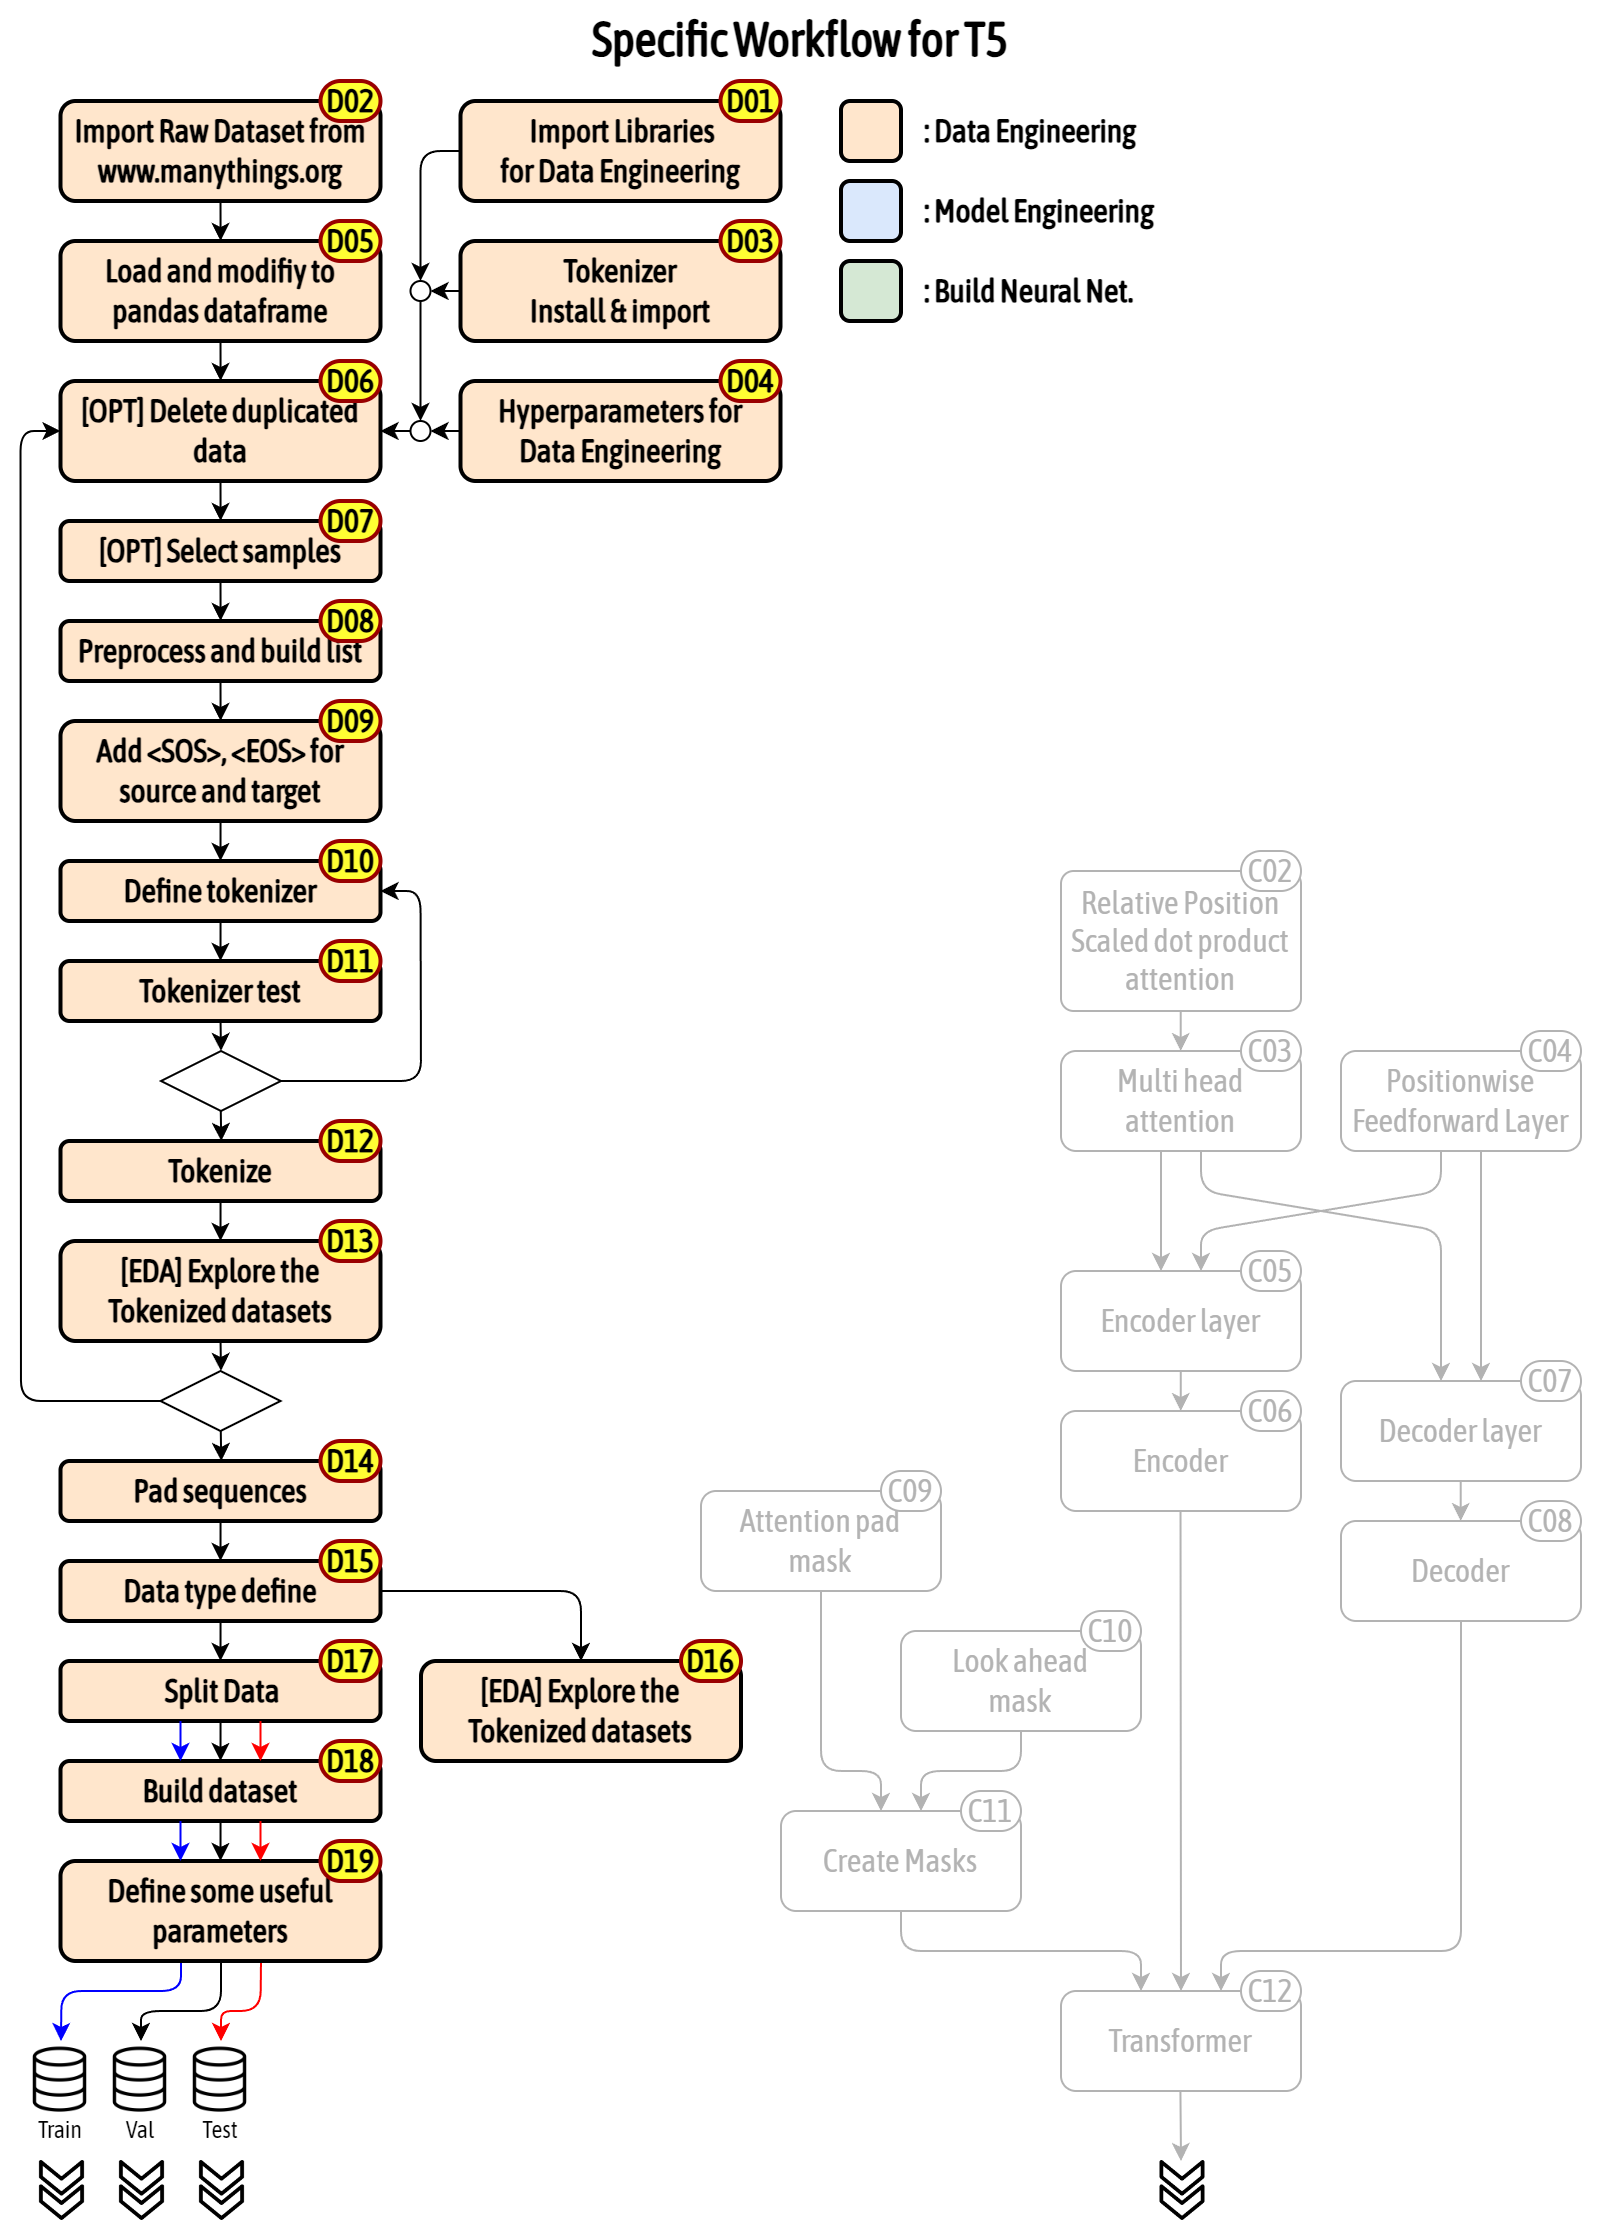

In [ ]:
'''
Data Engineering
'''

'''
D1. Import Libraries for Data Engineering
'''
import os
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import unicodedata

import torch
import random
# Setup seeds for reproducibility across random number generators in Python, NumPy, and PyTorch.
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
'''
D2. Import Raw Dataset from the specified URL
'''

! wget http://www.manythings.org/anki/fra-eng.zip
! unzip fra-eng.zip

--2024-07-19 09:21:27--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  28.7MB/s    in 0.3s    

2024-07-19 09:21:28 (28.7 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [ ]:
# for using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
D3. [PASS] Tokenizer Install & import
'''
# Keras Tokenizer is a tokenizer provided by default in tensorflow 2.X and is a word level tokenizer. It does not require a separate installation.


'\nD3. [PASS] Tokenizer Install & import\n'

In [ ]:
'''
D4. Define Hyperparameters for Data Engineering
'''
#length of the input sequence for the encoder and decoder ensuring uniformity in processing during training and inference.
ENCODER_LEN  = 41
DECODER_LEN  = ENCODER_LEN

#number of data samples processed in one iteration during training.
BATCH_SIZE   = 128

#total number of examples to be processed,12288
num_examples = 1024*12

In [ ]:
'''
D5. Load and modifiy to pandas dataframe
'''
import pandas as pd

pd.set_option('display.max_colwidth', None)

#Reads a CSV file (fra.txt) into a pandas DataFrame
train_df = pd.read_csv('fra.txt', names=['SRC', 'TRG', 'lic'], sep='\t')

del train_df['lic']
print(len(train_df))

train_df = train_df.loc[:, 'SRC':'TRG']

print(train_df.head())

#adding metadata (sentence lengths)
train_df["src_len"] = ""
train_df["trg_len"] = ""

print(train_df.head())

# [OPT] Count the number of words for source and target sentences
for idx in range(len(train_df['SRC'])):
    # initialize string
    text_eng = str(train_df.iloc[idx]['SRC'])

    # default separator: space
    result_eng = len(text_eng.split())
    train_df.at[idx, 'src_len'] = int(result_eng)

    text_fra = str(train_df.iloc[idx]['TRG'])
    # default separator: space
    result_fra = len(text_fra.split())
    train_df.at[idx, 'trg_len'] = int(result_fra)

print('Translation Pair :',len(train_df)) # Print Dataset Size

232736
   SRC         TRG
0  Go.        Va !
1  Go.     Marche.
2  Go.  En route !
3  Go.     Bouge !
4  Hi.     Salut !
   SRC         TRG src_len trg_len
0  Go.        Va !                
1  Go.     Marche.                
2  Go.  En route !                
3  Go.     Bouge !                
4  Hi.     Salut !                
Translation Pair : 232736


In [ ]:
'''
D6. [OPT] Delete duplicated data
'''

#ensuring each source and target sentence pair is unique
train_df = train_df.drop_duplicates(subset = ["SRC"])
print('Translation Pair :',len(train_df)) # Print Dataset Size

train_df = train_df.drop_duplicates(subset = ["TRG"])
print('Translation Pair :',len(train_df)) # Print Dataset Size

Translation Pair : 166561
Translation Pair : 148872


In [ ]:
train_df[:5]

SRC         TRG src_len trg_len
0    Go.        Va !       1       2
4    Hi.     Salut !       1       2
6   Run!     Cours !       1       2
22  Who?       Qui ?       1       2
23  Wow!  Ça alors !       1       3

In [ ]:
'''
D7. [OPT] Select samples
'''
# Assign the result to a new variable. include only rows between 8 and 20 sentence length
is_within_len = (8 < train_df['src_len']) & (train_df['src_len'] < 20) & (8 < train_df['trg_len']) & (train_df['trg_len'] < 20)
# Filter the data that meets the condition and store it in a new variable.
train_df = train_df[is_within_len]

# subset of train_df with num_examples randomly selected rows, all determined by the specified seed (1234).
dataset_df_8096 = train_df.sample(n=num_examples, # number of items from axis to return.
          random_state=1234) # seed for random number generator for reproducibility

print('Translation Pair :',len(dataset_df_8096))   # Print Dataset Size

Translation Pair : 12288


In [ ]:
dataset_df_8096[:5]

SRC  \
208183                                          She has a 10 percent interest in the company.   
231998  This movement from rural to urban areas has been going on for over two hundred years.   
224234                               There are a bunch of kids playing tag on the playground.   
223628                                 Have you paid your bill yet? "We most certainly have."   
187902                                                I think that it's too early to go home.   

                                                                                                       TRG  \
208183                                               Elle détient dix pour cent des parts de l'entreprise.   
231998  Ce mouvement des zones rurales vers les zones urbaines s'est poursuivi sur plus de deux-cents ans.   
224234                                Il y a une bande de gamins qui jouent au loup dans la cour de récré.   
223628                         « Avez-vous déjà payé votre facture ? » « Bien sûr que nous l'avons fait. »   
187902                                               Je pense qu'il est trop tôt pour rentrer à la maison.   

       src_len trg_len  
208183       9       9  
231998      16      16  
224234      11      16  
223628      10      16  
187902       9      11

Note: At this point, if required we can assign top required rows to dataset_df_8096 for the purpose of reducicg data size for speedy training.

In [ ]:
'''
D8. Preprocess and build list
'''
#These processed lists are typically used as input data for further preprocessing steps like tokenization and vectorization.
# Source Data
raw_src = []
for sentence in dataset_df_8096['SRC']:
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he's a boy." => "he 's a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    raw_src.append(sentence)

# Target Data
raw_trg = []

#Converts Unicode characters to ASCII using normalization.
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')

for sentence in dataset_df_8096['TRG']:
    # Converts each sentence to lowercase.
    sentence = unicode_to_ascii(sentence.lower())

    # Inserts spaces around punctuation (?.!,¿) for separation.
    # Ex) "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)

    # (a-z, A-Z, ".", "?", "!", ",") Removes non-alphabetic characters except punctuation
    sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)

    sentence = re.sub(r"\s+", " ", sentence)
    #Appends the processed sentences
    raw_trg.append(sentence)

print(raw_src[:5])
print(raw_trg[:5])

['she has a percent interest in the company .', 'this movement from rural to urban areas has been going on for over two hundred years .', 'there are a bunch of kids playing tag on the playground .', 'have you paid your bill yet ? we most certainly have .', 'i think that it is too early to go home .']
['elle detient dix pour cent des parts de l entreprise .', 'ce mouvement des zones rurales vers les zones urbaines s est poursuivi sur plus de deux cents ans .', 'il y a une bande de gamins qui jouent au loup dans la cour de recre .', ' avez vous deja paye votre facture ? bien sur que nous l avons fait . ', 'je pense qu il est trop tot pour rentrer a la maison .']


-----------To DO-------------


Write a code snippet that performs the processing on SRC and TRG together instead of them being done one after and other.


In [ ]:
# Write a code snippet that performs the processing on SRC and TRG together instead of them being done one after and other.

raw_src = []
raw_trg = []
for src_sentence, trg_sentence in zip(dataset_df_8096['SRC'], dataset_df_8096['TRG']):
    src_sentence = src_sentence.lower().strip()

    src_sentence = re.sub(r"([?.!,])", r" \1 ", src_sentence)
    src_sentence = re.sub(r'[" "]+', " ", src_sentence)
    src_sentence = re.sub(r"i'm", "i am", src_sentence)
    src_sentence = re.sub(r"he's", "he is", src_sentence)
    src_sentence = re.sub(r"she's", "she is", src_sentence)
    src_sentence = re.sub(r"it's", "it is", src_sentence)
    src_sentence = re.sub(r"that's", "that is", src_sentence)
    src_sentence = re.sub(r"what's", "that is", src_sentence)
    src_sentence = re.sub(r"where's", "where is", src_sentence)
    src_sentence = re.sub(r"how's", "how is", src_sentence)
    src_sentence = re.sub(r"\'ll", " will", src_sentence)
    src_sentence = re.sub(r"\'ve", " have", src_sentence)
    src_sentence = re.sub(r"\'re", " are", src_sentence)
    src_sentence = re.sub(r"\'d", " would", src_sentence)
    src_sentence = re.sub(r"\'re", " are", src_sentence)
    src_sentence = re.sub(r"won't", "will not", src_sentence)
    src_sentence = re.sub(r"can't", "cannot", src_sentence)
    src_sentence = re.sub(r"n't", " not", src_sentence)
    src_sentence = re.sub(r"n'", "ng", src_sentence)
    src_sentence = re.sub(r"'bout", "about", src_sentence)
    src_sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", src_sentence)
    src_sentence = src_sentence.strip()
    raw_src.append(src_sentence)

    # Converts each sentence to lowercase.
    trg_sentence = unicode_to_ascii(trg_sentence.lower())

    # Inserts spaces around punctuation (?.!,¿) for separation.
    # Ex) "he is a boy." => "he is a boy ."
    trg_sentence = re.sub(r"([?.!,¿])", r" \1", trg_sentence)

    # (a-z, A-Z, ".", "?", "!", ",") Removes non-alphabetic characters except punctuation
    trg_sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", trg_sentence)

    trg_sentence = re.sub(r"\s+", " ", trg_sentence)
    #Appends the processed sentences
    raw_trg.append(trg_sentence)

print(raw_src[:5])
print(raw_trg[:5])



['she has a percent interest in the company .', 'this movement from rural to urban areas has been going on for over two hundred years .', 'there are a bunch of kids playing tag on the playground .', 'have you paid your bill yet ? we most certainly have .', 'i think that it is too early to go home .']
['elle detient dix pour cent des parts de l entreprise .', 'ce mouvement des zones rurales vers les zones urbaines s est poursuivi sur plus de deux cents ans .', 'il y a une bande de gamins qui jouent au loup dans la cour de recre .', ' avez vous deja paye votre facture ? bien sur que nous l avons fait . ', 'je pense qu il est trop tot pour rentrer a la maison .']


In [ ]:
'''
D9. Add <SOS>, <EOS> for source and target
'''
SRC_df = pd.DataFrame(raw_src)
TRG_df = pd.DataFrame(raw_trg)

SRC_df.rename(columns={0: "SRC"}, errors="raise", inplace=True)
TRG_df.rename(columns={0: "TRG"}, errors="raise", inplace=True)
#Renames and concatenates raw_src and raw_trg into train_df
train_df = pd.concat([SRC_df, TRG_df], axis=1)

print('Translation Pair :',len(train_df)) # total number of translation pairs
print(train_df.sample(10))

raw_src_df  = train_df['SRC']
raw_trg_df  = train_df['TRG']

#adding <SOS> (Start of Sentence) and <EOS> (End of Sentence) tokens to both source (SRC) and target (TRG) sentences
src_sentence  = raw_src_df.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
trg_sentence  = raw_trg_df.apply(lambda x: "<SOS> "+ x + " <EOS>")

Translation Pair : 12288
                                                                             SRC  \
1860   i wish you would tell me what i ought to do in this difficult situation .   
7020                          we did not think it would be possible to do that .   
6412                          i do not have a brother , but i have two sisters .   
9719                                     you might want to take a look at this .   
7909                      he got up early so he would be in time for the train .   
9780            we were unable to make contact with them until it was too late .   
2315               tom said he did not have time to answer all of my questions .   
10094                  i do not think we can move this piano without some help .   
367                                i do not know how to tell tom this bad news .   
1716          i think you owe me about thirty dollars . that seems about right .   

                                                  

In [ ]:
print(src_sentence[89])
trg_sentence[89]

<SOS> it is not what you wear , it is how you wear it . <EOS>


'<SOS> le probleme ce n est pas ce que tu portes mais comment tu le portes . <EOS>'

In [ ]:
'''
D10. Define tokenizer
'''
#specify characters that should be filtered out during tokenization
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

#Sets an out-of-vocabulary token (oov_token) to <unk> (unknown) for handling words not seen during training.
oov_token = '<unk>'

#Initializes tokenizers
SRC_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
TRG_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)

#Fits SRC_tokenizer and TRG_tokenizer on preprocessed src_sentence and trg_sentence, respectively, to build vocabulary indices.
SRC_tokenizer.fit_on_texts(src_sentence)
TRG_tokenizer.fit_on_texts(trg_sentence)

#Creates dictionaries (src_to_index and index_to_src for source, tar_to_index and index_to_tar for target) to map words to indices and vice versa.
src_to_index = SRC_tokenizer.word_index
index_to_src = SRC_tokenizer.index_word

tar_to_index = TRG_tokenizer.word_index
index_to_tar = TRG_tokenizer.index_word

#Tokenizers typically start indexing words from 1, not 0. The index 0 is reserved for the padding token (<PAD>),
#Calculates vocabulary sizes (n_enc_vocab for encoder and n_dec_vocab for decoder) by adding 1 to the length of the respective tokenizer's word index.
n_enc_vocab = len(SRC_tokenizer.word_index) + 1 #By adding 1, we account for the padding token (index 0).
n_dec_vocab = len(TRG_tokenizer.word_index) + 1 #This ensures that the vocabulary size includes all possible tokens, including the padding.

#This setup prepares the tokenizers and vocabulary mappings necessary for converting text data into numerical sequences suitable for neural network training.
print('Word set size of Encoder :',n_enc_vocab)
print('Word set size of Decoder :',n_dec_vocab)

Word set size of Encoder : 7108
Word set size of Decoder : 9498


In [ ]:
'''
D11. Tokenizer test
'''
#tokenize sentences into token IDs and convert them back into text using separate tokenizers for source (English) and target (French) languages,
# Source Tokenizer
lines = [
  "It is winter and the weather is very cold.",
  "Will this Christmas be a white Christmas?",
  "Be careful not to catch a cold in winter and have a happy new year."
]
for line in lines:
    #TODO
    #Converts sentences in English (lines) into sequences of token IDs (txt_2_ids) and vice versa using SRC_tokenizer.
    txt_2_ids = SRC_tokenizer.texts_to_sequences([line])[0]
    print("English Text to IDs:", txt_2_ids)
    ids_2_txt = SRC_tokenizer.sequences_to_texts([txt_2_ids])[0]
    print("IDs to English text:", ids_2_txt)
    print()

# Target Tokenizer
lines = [
  "C'est l'hiver et il fait très froid.",
  "Ce Noël sera-t-il un Noël blanc ?",
  "Attention à ne pas attraper froid en hiver et bonne année."
]
for line in lines:
    #TODO
    #Converts sentences in French (lines) into sequences of token IDs (txt_2_ids) using TRG_tokenizer.
    txt_2_ids = TRG_tokenizer.texts_to_sequences([line])[0]
    print("French Text to IDs:", txt_2_ids)
    ids_2_txt = TRG_tokenizer.sequences_to_texts([txt_2_ids])[0]
    print("IDs to French text:", ids_2_txt)
    print()

English Text to IDs: [15, 10, 732, 22, 4, 410, 10, 90, 312]
IDs to English text: it is winter and the weather is very cold

English Text to IDs: [28, 24, 141, 27, 8, 507, 141]
IDs to English text: will this christmas be a white christmas

English Text to IDs: [27, 473, 9, 5, 370, 8, 312, 13, 732, 22, 18, 8, 383, 120, 180]
IDs to English text: be careful not to catch a cold in winter and have a happy new year

French Text to IDs: [1, 1, 31, 11, 57, 1, 445]
IDs to French text: <unk> <unk> et il fait <unk> froid

French Text to IDs: [17, 1, 246, 69, 11, 14, 1, 734]
IDs to French text: ce <unk> sera t il un <unk> blanc

French Text to IDs: [433, 1, 13, 10, 670, 445, 25, 796, 31, 188, 1]
IDs to French text: attention <unk> ne pas attraper froid en hiver et bonne <unk>



Source (SRC): This refers to the input sequences (sentences) in the original language that you want to translate. These sequences are fed into the encoder of the sequence-to-sequence model.

Target (TRG): This refers to the output sequences (translated sentences) in the target language. These sequences serve as the training data for the decoder of the sequence-to-sequence model.

In [ ]:
'''
D12. Tokenize
'''
# tokenize / encode integers / add start and end tokens / padding
#tokenizing input (src_sentence) and output (trg_sentence) sentences into sequences of token IDs using SRC_tokenizer and TRG_tokenizer r
tokenized_inputs      = SRC_tokenizer.texts_to_sequences(src_sentence)
tokenized_outputs     = TRG_tokenizer.texts_to_sequences(trg_sentence)

"SOS" AND "EOS" tokenized in input sequence of source and target set

unk = 1
SOS = 2
EOS = 3

In [ ]:
print('Tokenized Inputs:', tokenized_inputs)

Tokenized Inputs: [[2, 36, 73, 8, 877, 1336, 13, 4, 343, 3], [2, 24, 3758, 65, 3759, 5, 2742, 2743, 73, 87, 72, 26, 20, 150, 136, 765, 139, 3], [2, 46, 29, 8, 2182, 11, 559, 560, 2744, 26, 4, 2183, 3], [2, 18, 7, 572, 41, 1225, 301, 25, 177, 1226, 18, 3], [2, 6, 43, 14, 15, 10, 115, 255, 5, 52, 117, 3], [2, 6, 28, 27, 1337, 5, 7, 31, 7, 47, 12, 14, 20, 23, 3], [2, 16, 28, 27, 154, 5, 1141, 8, 2184, 31, 6, 49, 32, 7, 3], [2, 6, 28, 514, 7, 39, 4, 210, 39, 8, 803, 3], [2, 148, 878, 23, 5, 192, 7, 8, 203, 413, 3], [2, 36, 129, 5, 4, 210, 5, 84, 50, 125, 3], [2, 33, 6, 121, 34, 5, 12, 10, 5, 54, 88, 290, 3], [2, 4, 359, 3760, 19, 26, 4, 1849, 744, 384, 344, 11, 2745, 4, 309, 3], [2, 17, 368, 66, 12, 14, 38, 195, 38, 6, 47, 3], [2, 33, 10, 4, 587, 843, 305, 13, 4, 169, 3], [2, 70, 159, 8, 766, 529, 13, 335, 11, 4, 1850, 1479, 3], [2, 24, 10, 4, 2746, 4, 844, 22, 2185, 204, 13, 3], [2, 21, 1851, 709, 13, 8, 664, 369, 118, 117, 3], [2, 17, 365, 57, 5, 42, 16, 10, 9, 530, 26, 974, 55, 5, 710, 

Maximum length of source including special tokens: 23
Average length of source including special tokens: 13.128092447916666


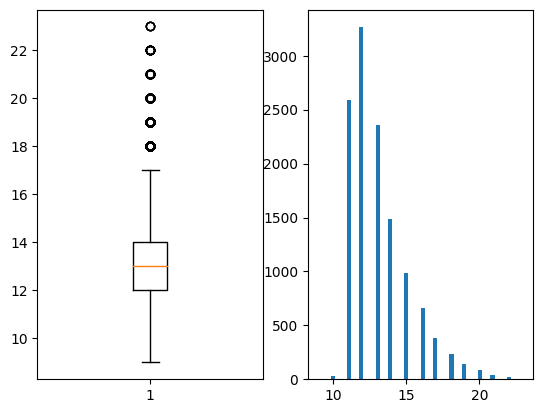

Maximum length of target : 26
Average length of target : 14.271647135416666


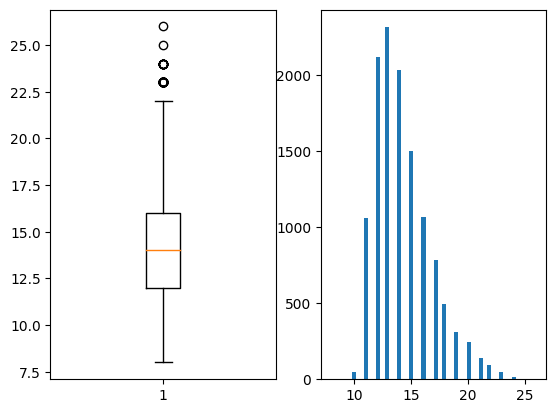

In [ ]:
'''
D13. [EDA] Explore the tokenized datasets
'''

len_result = [len(s) for s in tokenized_inputs]

print('Maximum length of source including special tokens: {}'.format(np.max(len_result)))
print('Average length of source including special tokens: {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()


len_result = [len(s) for s in tokenized_outputs]

print('Maximum length of target : {}'.format(np.max(len_result)))
print('Average length of target : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [ ]:
'''
D14. Pad sequences
'''

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences of tokenized source inputs to a fixed length (ENCODER_LEN).
# If a sequence is shorter than ENCODER_LEN, it will be padded with zeros at the end ('post').
# Padding token (index 0) is different from <unk> (index 1).
# If a sequence is longer than ENCODER_LEN, it will be truncated at the end ('post').
tkn_sources = pad_sequences(tokenized_inputs,  maxlen=ENCODER_LEN, padding='post', truncating='post')
tkn_targets = pad_sequences(tokenized_outputs, maxlen=DECODER_LEN, padding='post', truncating='post')

test!!!

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sample tokenized input sequences
tokenized_inputs_t = [
    [1, 2, 13, 4, 5,3],
    [2, 6, 7, 8, 3],
    [2, 9, 10, 11, 12, 13, 14, 15,3]
]

# Sample tokenized target sequences
tokenized_outputs_t = [
    [2, 16, 17, 18,1,3],
    [2, 9, 20, 21, 22, 23,3],
    [2, 1,1,24, 25,3]
]

#TODO
# Define the desired sequence lengths
encoder_len = ENCODER_LEN
decoder_len = DECODER_LEN

# Pad sequences of tokenized source inputs to a fixed length (encoder_len)
padded_inputs = pad_sequences(tokenized_inputs_t, maxlen=encoder_len, padding='post', truncating='post')

# Pad sequences of tokenized target outputs to a fixed length (decoder_len)
padded_outputs = pad_sequences(tokenized_outputs_t, maxlen=decoder_len, padding='post', truncating='post')

# Print the results, source and target sequences with padding
print("Source Sequences with Padding:")
print(padded_inputs)
print("Shape:", padded_inputs.shape)
print()

print("Target Sequences with Padding:")
print(padded_outputs)
print("Shape:", padded_inputs.shape)

Source Sequences with Padding:
[[ 1  2 13  4  5  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  6  7  8  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  9 10 11 12 13 14 15  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Shape: (3, 41)

Target Sequences with Padding:
[[ 2 16 17 18  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  9 20 21 22 23  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  1 24 25  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Shape: (3, 41)


In [ ]:
'''
D15. Data type define
'''

tensors_src   = torch.tensor(tkn_sources).to(device)
tensors_trg   = torch.tensor(tkn_targets).to(device)

In [ ]:
'''
D16. [EDA] Explore the Tokenized datasets
'''
print('Size of source language data(shape) :', tkn_sources.shape)
print('Size of target language data(shape) :', tkn_targets.shape)

# Randomly output the 0th sample
print(tkn_sources[0])
print(tkn_targets[0])

Size of source language data(shape) : (12288, 41)
Size of target language data(shape) : (12288, 41)
[   2   36   73    8  877 1336   13    4  343    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[   2   36 3364  273   19  666   34 4786    4   15  396    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
'''
D17. [PASS] Split Data
'''

'\nD17. [PASS] Split Data\n'

In [ ]:
'''
D18. Build dataset
'''

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

dataset    = TensorDataset(tensors_src, tensors_trg)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) #Indicates whether to shuffle the data every time an epoch ends and a new epoch begins. Shuffling the data helps in randomizing the order of samples in each batch, which is crucial for improving training performance and preventing the model from memorizing the order of examples.

In [ ]:
tensors_src[0]

tensor([   2,   36,   73,    8,  877, 1336,   13,    4,  343,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0], dtype=torch.int32)

In [ ]:
'''
D19. [PASS] Define some useful parameters
'''

'\nD19. [PASS] Define some useful parameters\n'

# About T5

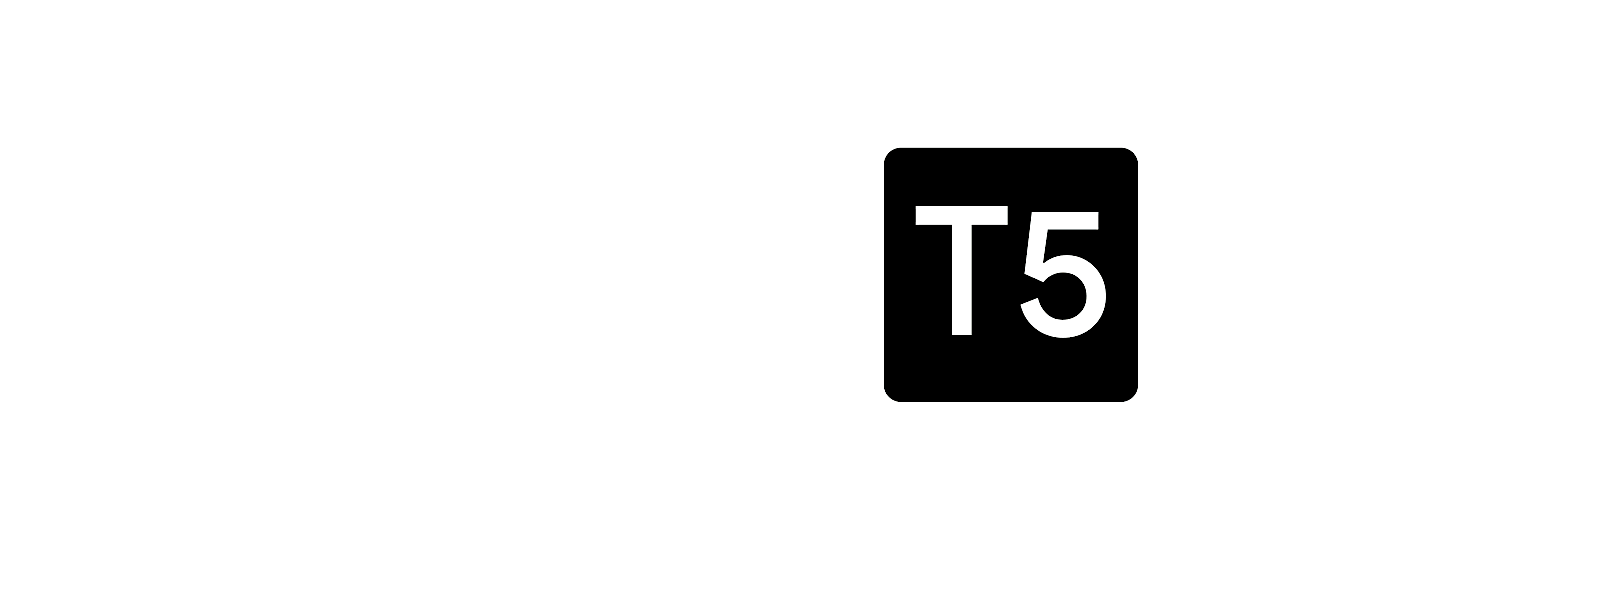

- Open-sourced near December 2019 by Google
- Unified text-to-text-format framework that provided a single, consistent way to approach a wide range of language tasks by converting everything into a text-to-text format. This made it easier to compare different models and methods.This is done by appending a task-specific prefix to the textual input (i.e., so that T5 knows what task it is trying to solve) and using the decoder module of T5 to generate text corresponding to the desired target (e.g., a label, regression value, or sequence of text). Similar to prompting and few-shot learning techniques used for LLMs that you '' ll cover in fothcoming weeks.
- Self supervised pre-training over 700GB in size on cleaned web-crawled text C4 (Colossal Clean Crawled Corpus)
- Fine tuned to any fo the tasks like Chatbot, Translation, Text Summarisation, Sentence Similarity, etc.
-  T5 is a standard encoder-decoder architecture


Note: The transfer learning paradigm is comprised of two main stages. First, we pre-train a deep neural network over a bunch of data. Then, we fine-tune this model (i.e., train it some more) over a more specific, downstream dataset. In  (NLP), we often perform self-supervised pre-training over an unlabeled textual corpus. Can you sense WHY??

In self supervised pretraining, the model learns to understand language patterns and structure by predicting missing parts of text or other tasks that don't require human-labeled data

# Module 2- Model Engineering

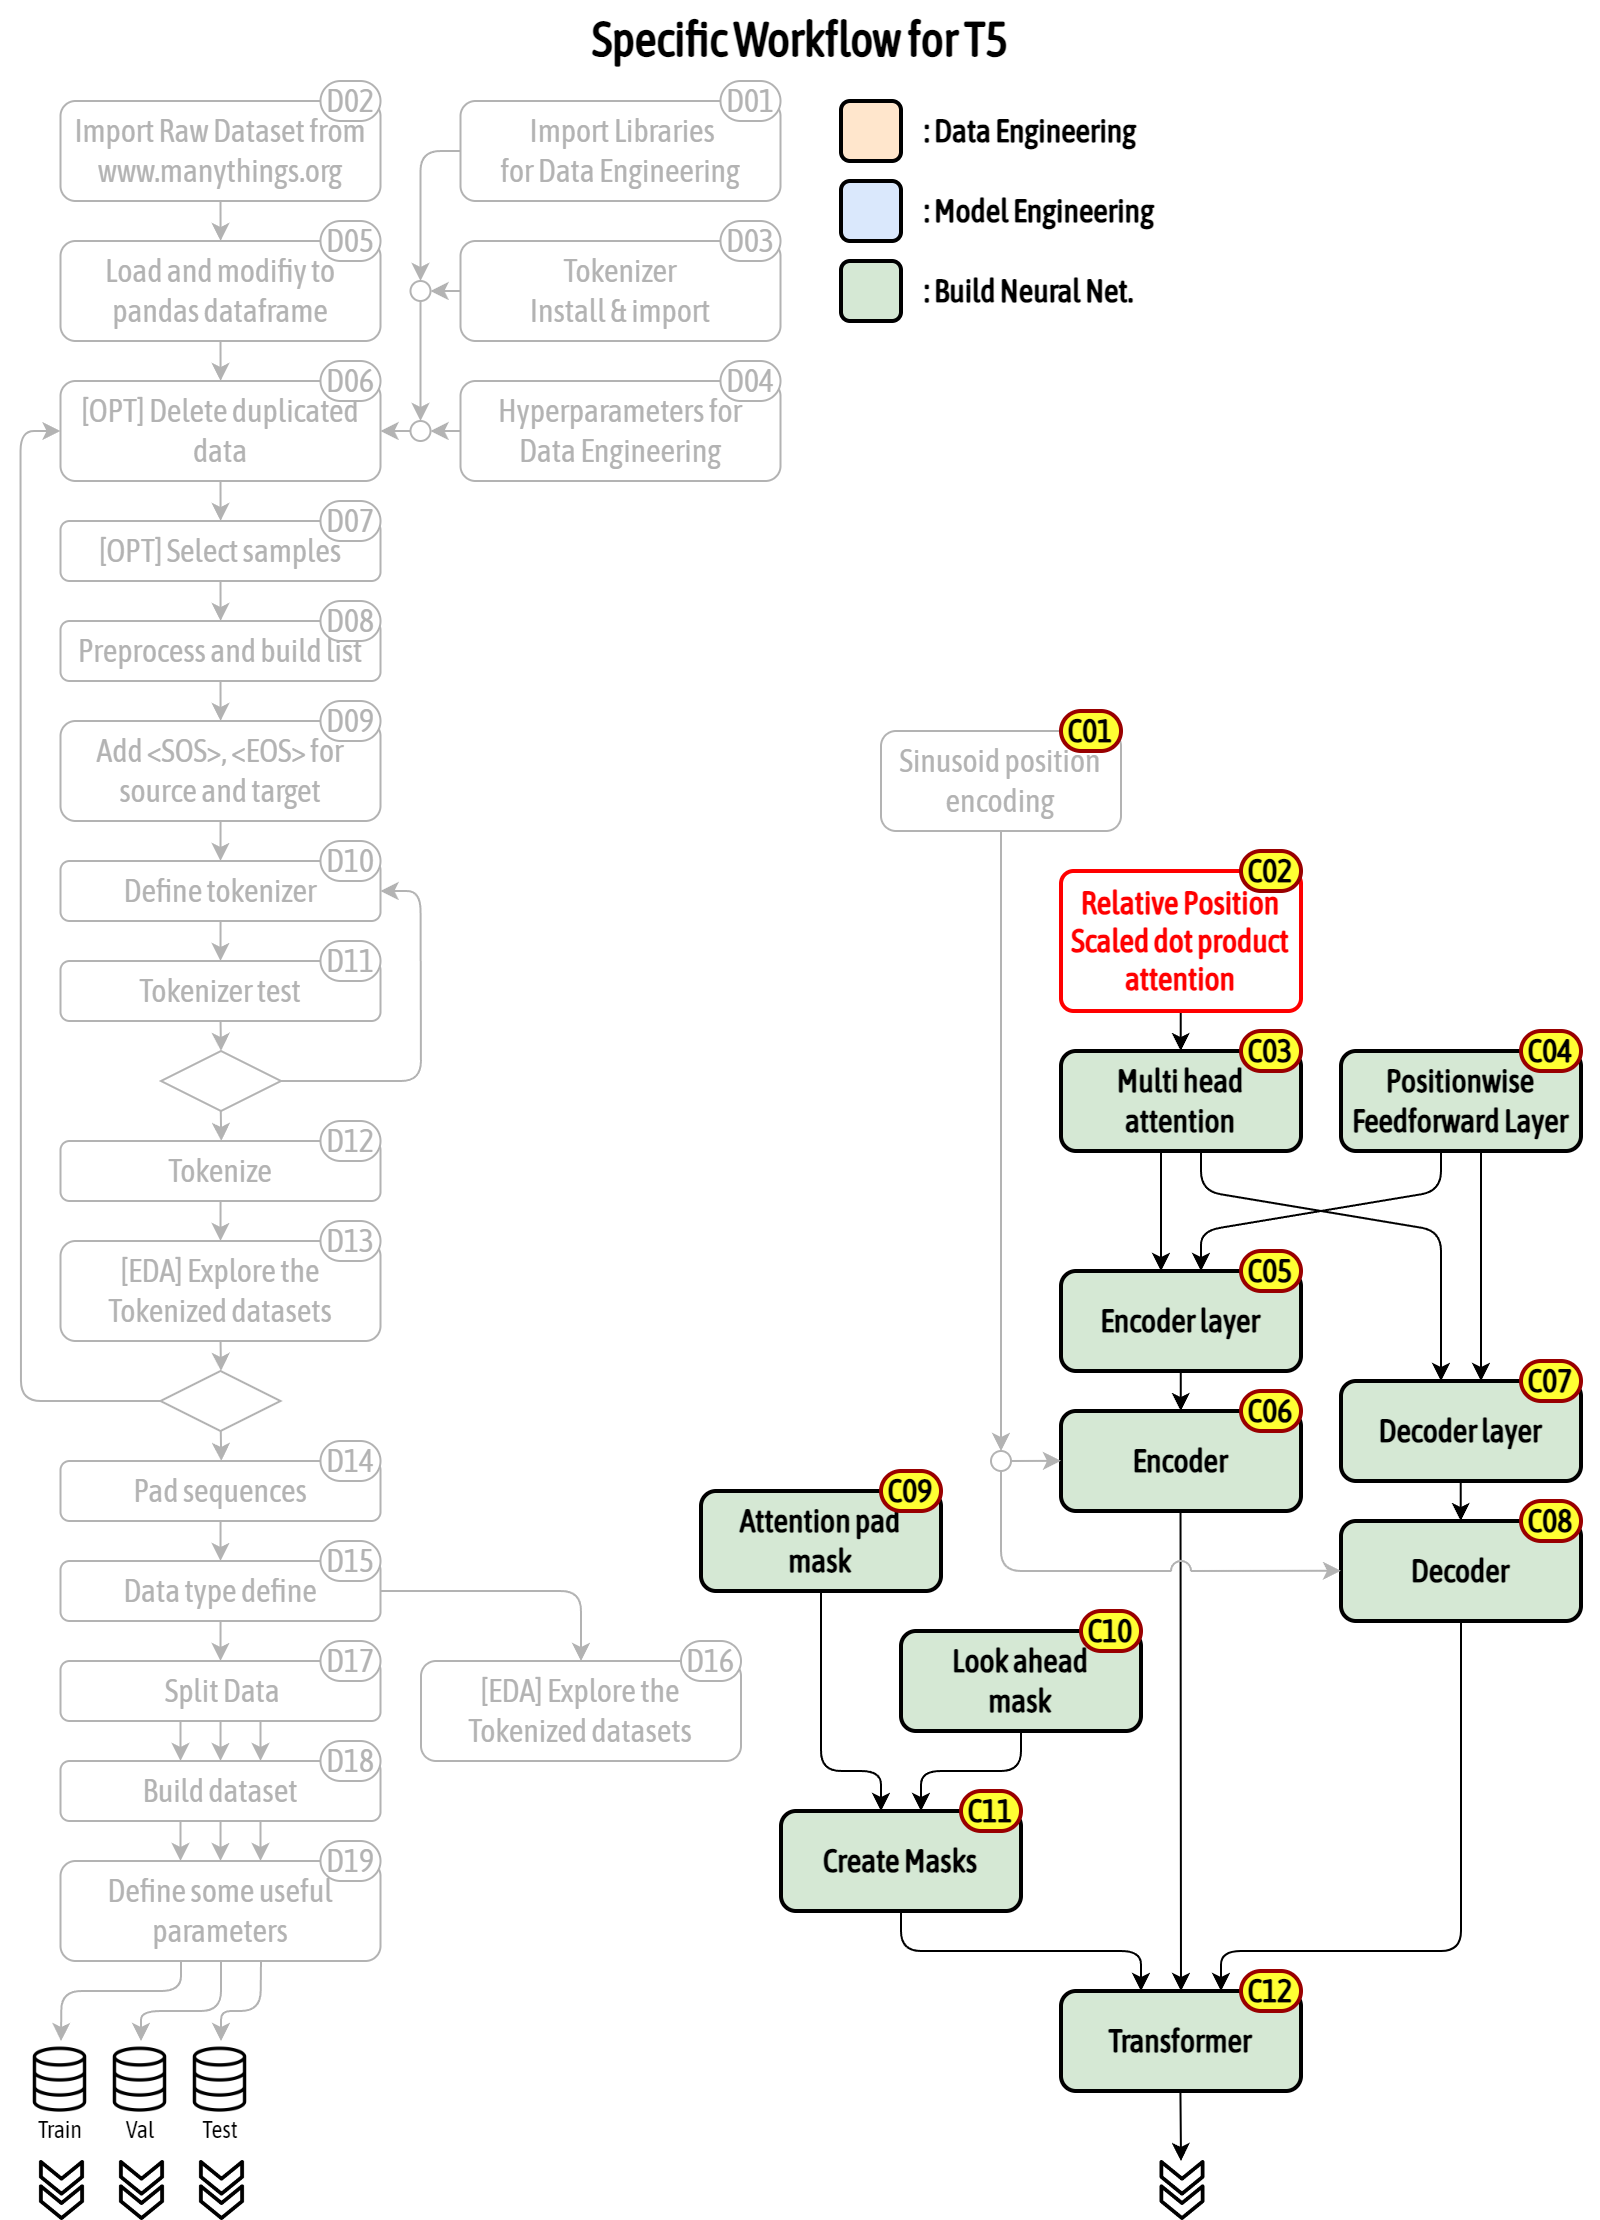

In [ ]:
'''
Model Engineering
'''

'''
M01. Import Libraries for Model Engineering
'''
import torch
from tqdm import tqdm, tqdm_notebook, trange #allows you to visualize the progress of your iteration, showing a progress bar with estimated time remaining and other statistics.

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

In [ ]:
'''
M02. Define Hyperparameters for Model Engineering
'''
n_layers  = 2     # 6
hid_dim   = 256
pf_dim    = 1024
n_heads   = 8
dropout   = 0.3
pe_input  = 512
pe_target = 512
layer_norm_epsilon = 1e-12
N_EPOCHS  = 10  #epochs for training

In [ ]:
'''
M03. [PASS] Load datasets
'''

'\nM03. [PASS] Load datasets\n'

In [ ]:
'''
M04. Build Transformer model
'''

"""
C01. [Not Used] Sinusoid position encoding
"""

'\nC01. [Not Used] Sinusoid position encoding\n'

# Hands On Relative Position Encoding - From Scratch

## Recall Transformer Architecture 😀


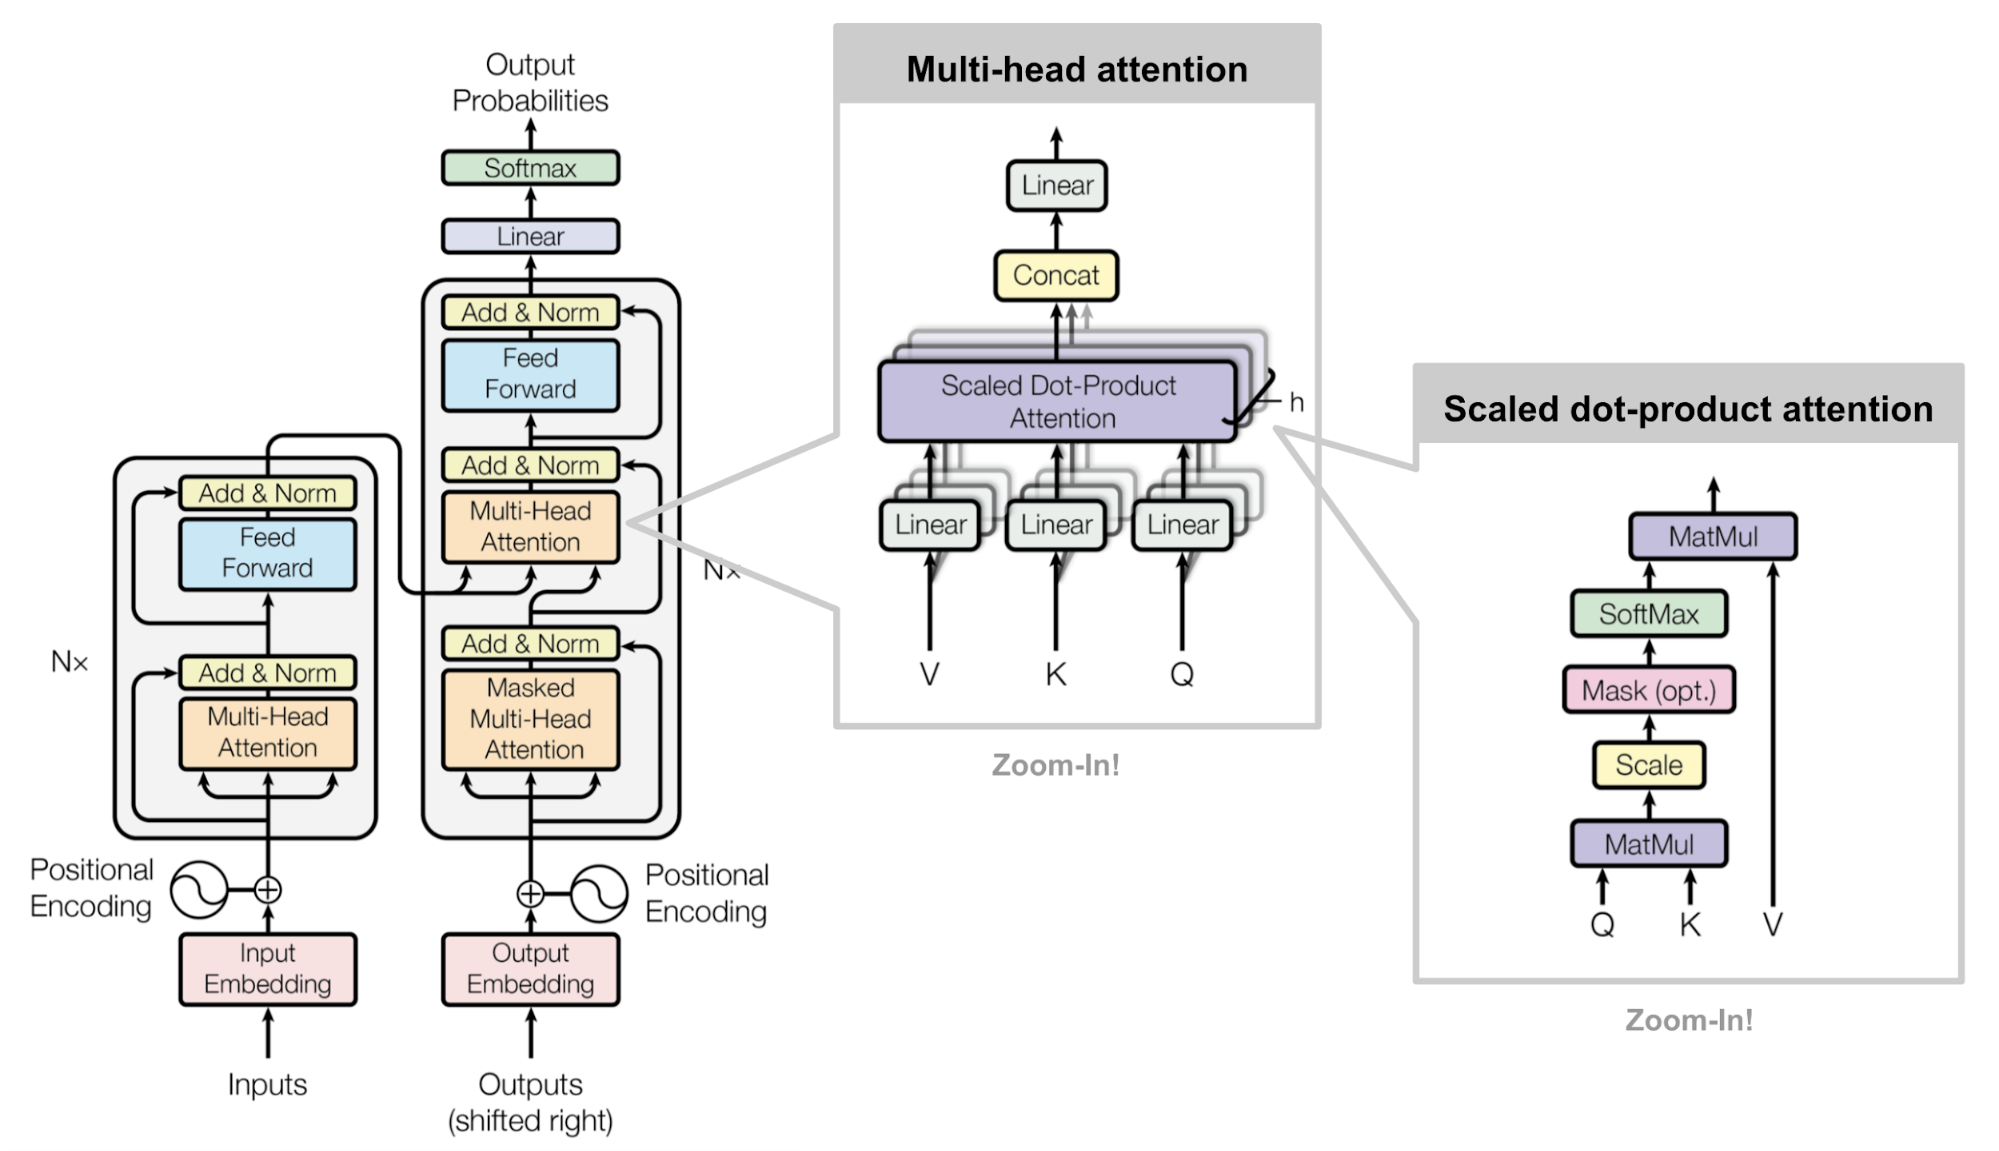

T5 vs Original Transformer Architecture T5 uses an encoder-decoder architecture that closely resembles the original transformer. Few modifications:

- No additive bias is used for LayerNorm (i.e., see https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html; we only use scale and eliminate the additive bias)

- LayerNorm is applied immediately before each attention and feed forward transformation (i.e., outside of the residual path)

- A different position embedding scheme is used that *adds a scalar* to the corresponding logit used to compute attention weights

- Dropout is applied throughout the network (e.g., attention weights, feed forward network, skip connection, etc.)

## T5 Architecture!!

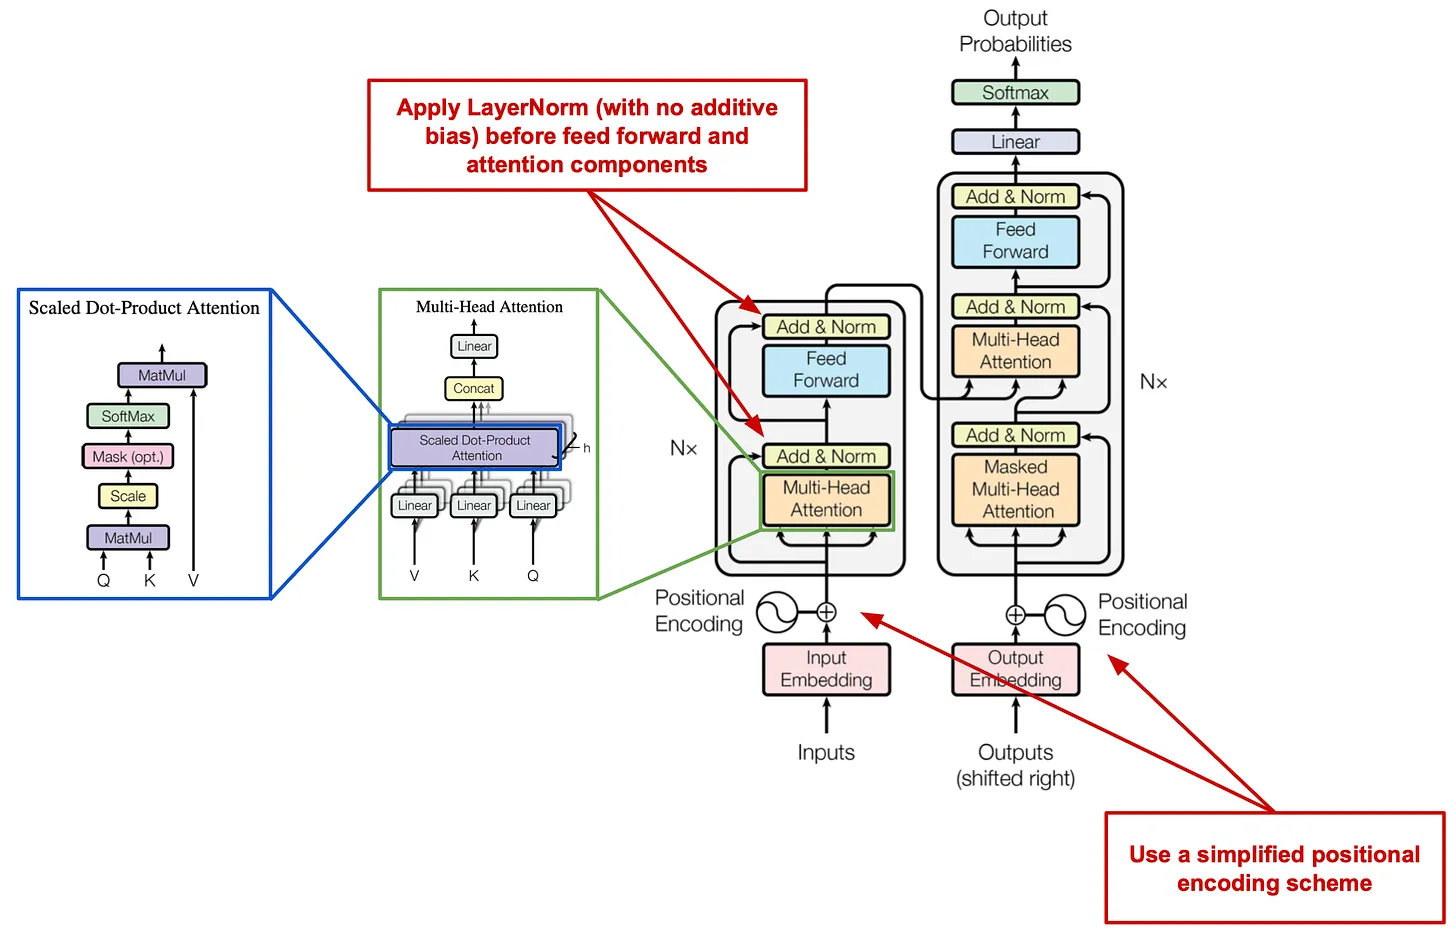

Side Note : While BERT primarily focuses on masked language modeling and next sentence prediction during pre-training, T5 uses a unified text-to-text framework, allowing it to handle a broader range of tasks with more customization options.

## The Complete Picture

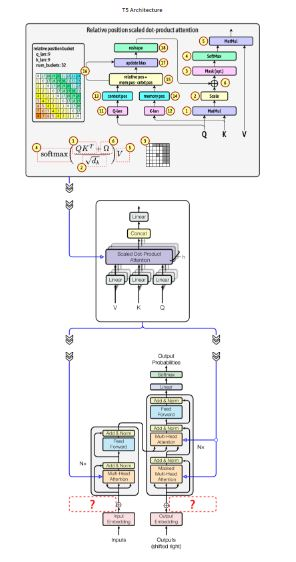

## The Scalar to add!!


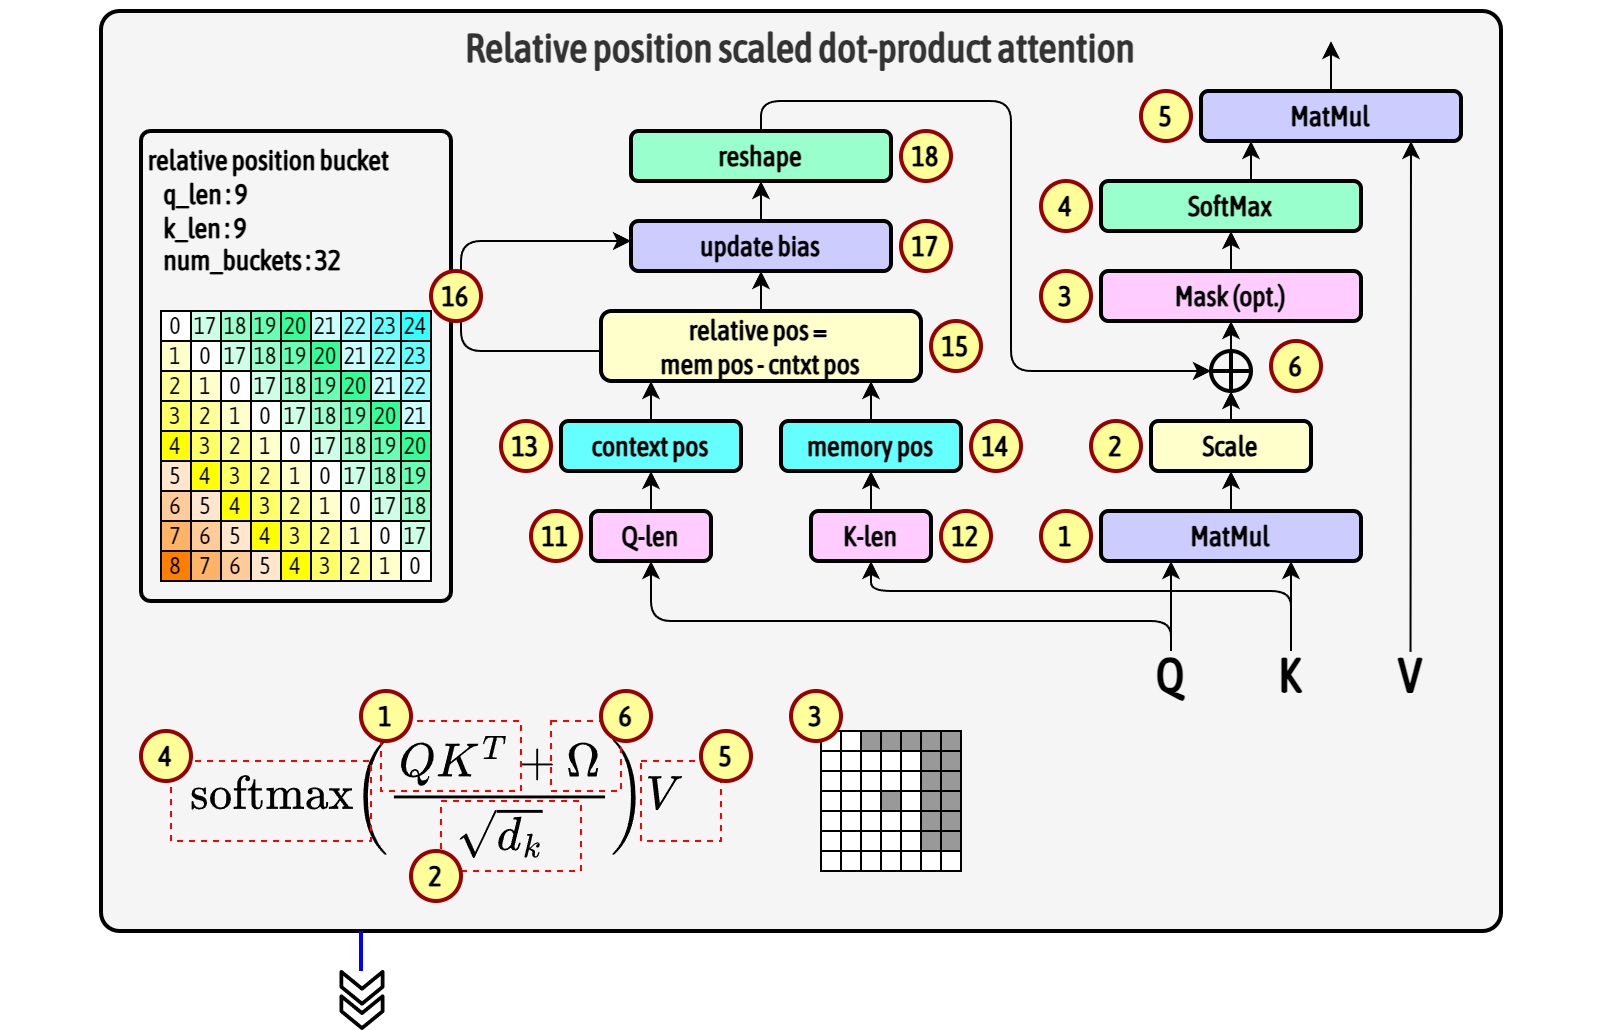

## Lets have some Intution First!

Transformer is a language model which is position-aware feed forward neural networks. Attention computes similarity between vectors. They “read” the whole sentence at once. Each word gets represented given it’s own position and all the others words in the sentence and their positions.Overall, the Transformer actually knows the order of the words as well, these are encoded in a separate positional vector. The positional vector is then merged with the vector that represents the similarities between each word and after that it is passed to a feed forward layer in the encoder.

- Positional encoding introduced by Attention is All You Need, introduces absolute positional embeddings. Exact order of tokens is encoded, such that the transformer is informed about the sequential nature of the data.
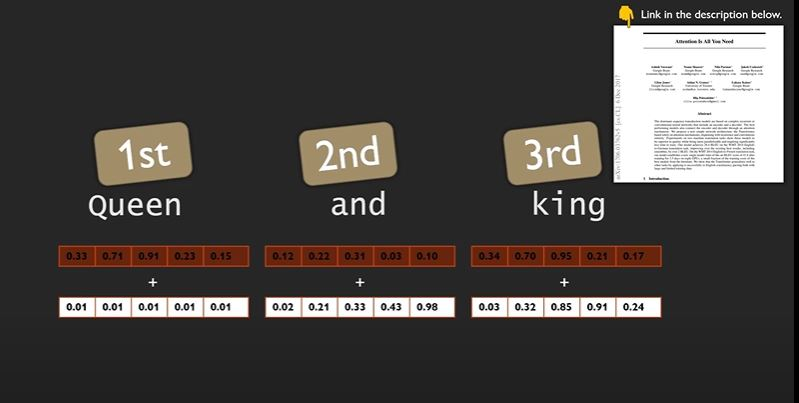

- Otherwise, the transformer that is  processing everything in parallel,would be invariant to order, meaning that without positional encodings, its output would  not change after complete sequence reordering.
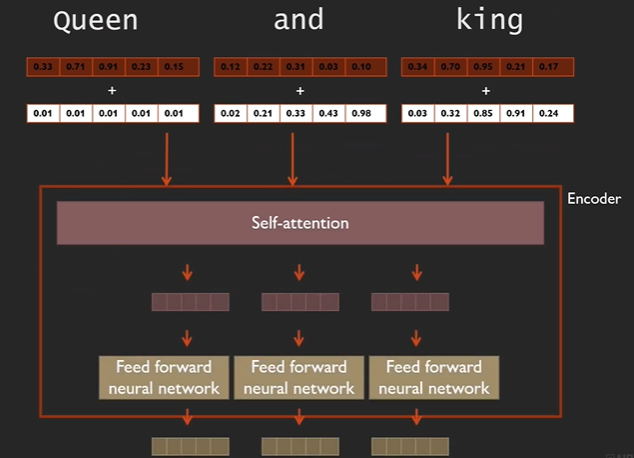

- 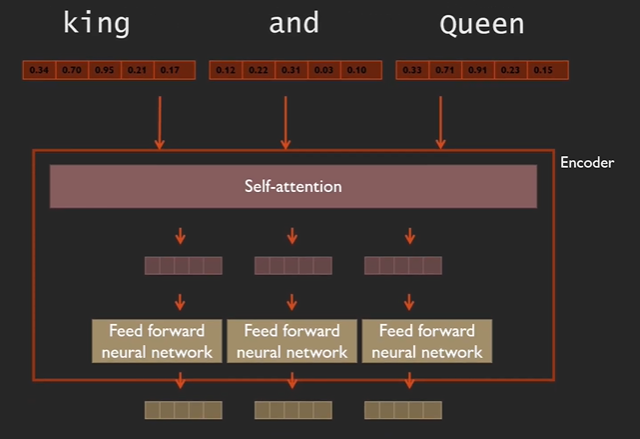


Questions to Ponder!!!
- Problem with Absolute Poition Encoding? decreases the model's generability preventing models from generalizing well to sequence lengths longer than those encountered during training, limiting their generability. Limited Range of Positional Encoding: Absolute positional encodings are often defined based on a fixed range, such as the maximum sequence length encountered during training. If the model encounters sequences longer than this maximum length, tokens towards the end of the sequence may not have accurate or meaningful positional encodings.
- What if we want to preserve the order of sequence relatively (the distance between tokens)?

- let's say we have this image with this,person at the left corner,what we do is that we divide this image,into equal size patches and by adding absolute position embedding we can say,the patch at the top left is the first,patch the next one is the second patch so on. but let's just focus only on the second patch which is our second token we can see that it has things like his left eye or part of his hair and his left ear

- 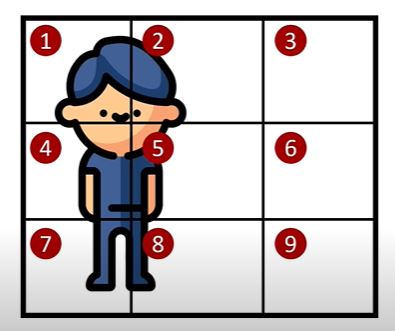


- but if we just translate this image and move it to the right corner now all of the features like his left eye and left ear and part of his hair is on the third patch while they're exactly the same, they are just concatenated with different absolute position embedding so our Transformer should consider this differently and generates a different sort of outputs but they are exactly the same and they shouldn't be treated different.

- 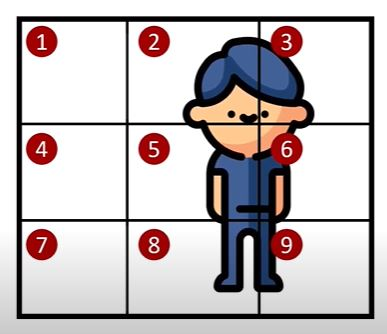


so how can we solve this well?? We can rely on relative position bias!

- In relative position bias when we have an image we can only focus on one single token like for example the right patch and consider this as our origin that has x0 which is the green circle and Y0 which is our yellow circle

- 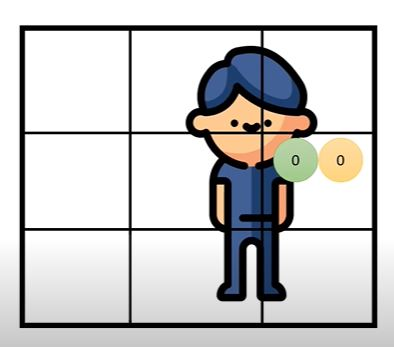

- and now if we just for example go one step to the top, then our position would be 0 , 1 and if we go one step to the bottom then our position would be 0,-1 and likewise.and we have these sort of positions.

- 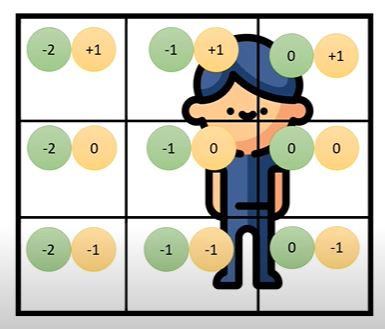

- and now let's just say our origin is not the right patch but instead it is our top right so that's my origin 0,0 and say if we go one step to the left it would be -1,0 and so on..but what's the purpose of doing this?

- 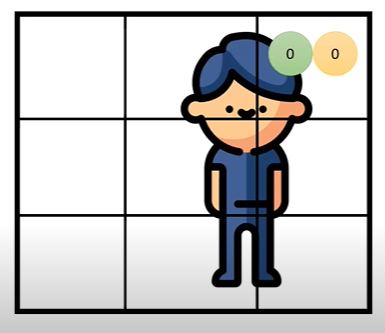

- 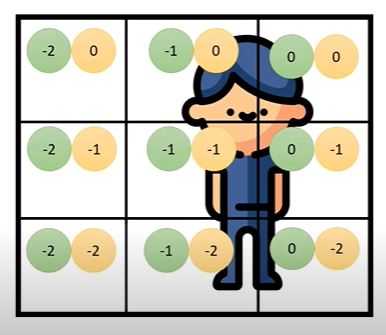
- now if we translate this person from the right to the left the absolute positions will be translated accordingly and they are exactly the same as like they used to be and there is no difference with when these tokens and what they initially were but yeah we have three tokens at the right and they are new so we can just Define what are the relative positions for them as well and we have this image at least for these six tokens that we have for the left they are exactly what like what they used to be and their outputs would be the same but
using this relative position bias idea, position bias is just to preserve the order relatively for each patch that we have in the image.

- 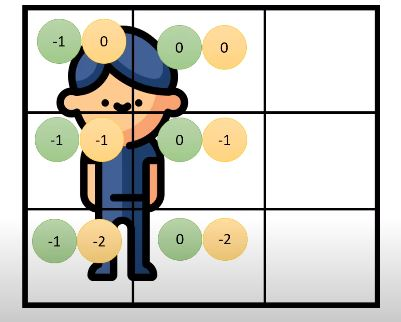

- 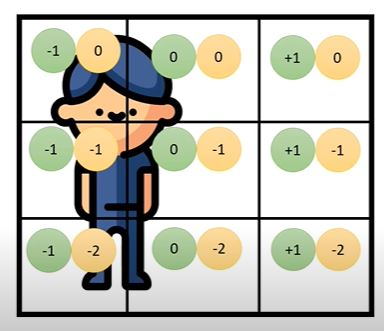

- So relative positions are about the distances  between elements in either a graph, or a sequence -- which is in  fact a degenerate graph, a chain.A follow-up paper OF 'Attention is all you need!' doing exactly this: they introduce relative  positional encodings where not the order, but the
relation or better said: the relative position,  the distance between tokens is important.

- 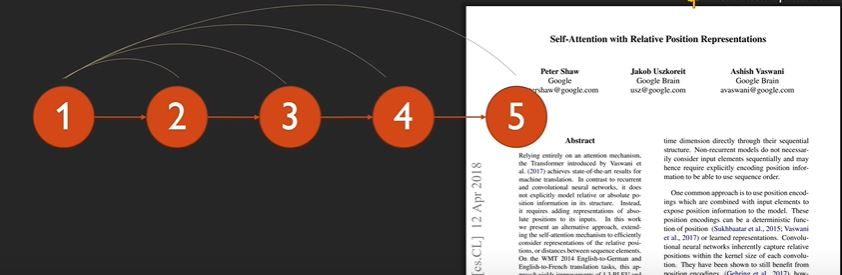

- The idea of relative embeddings is moving away  from the classical positional embeddings where each token has its own positional embedding.

- 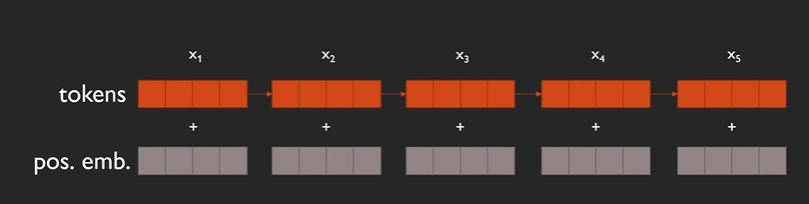


- With relative representations, each word or token  does not have only one positional embedding, but as many positional embeddings  as there are tokens in the sequence,  in order to describe the  relationship between them. This is because relative positional  representations do not encode absolute  order anymore, but the positional relationship  in which each token stands to the other tokens.

- 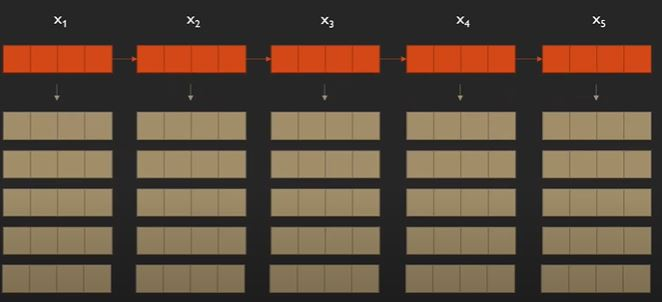


- So, let’s take an example sequence of 5 tokens. In classical positional embeddings, each token --  let’s say x_4 here -- has one encoding informing  the transformer about the position of x_4. In the relative variant, each token  has 5 positional embeddings. One embedding for describing  its relative position to itself,  then 4 others for the rest of the sequence. And to keep the same notation as the original  paper, the positional embedding  describing the relationship  of one token with itself is a vector w_0, as 0 is the distance between the token and itself. Then w_1, w_2 as we move to the right and w_-1  and w_-2 and so on, as we move to the left.And the vector w_i takes the  same value, independently of  what token we are currently looking at, because w_0 -- wherever we are -- says that we are 0 hops away in the graph. w_-1 says that we are one hop away to  the left in a sequence ; or in a directed graph in  general, we go one hop following outgoing edges.
- 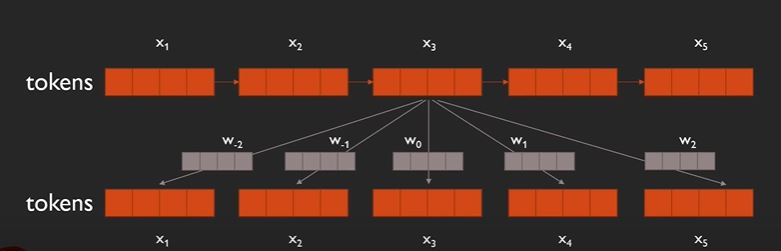

- Now, For a sequence of length five,  positional embeddings should  range from w_-4 to w_4, so we have in total 9 positional embeddings to  either handcraft or learn for this sequence.

- 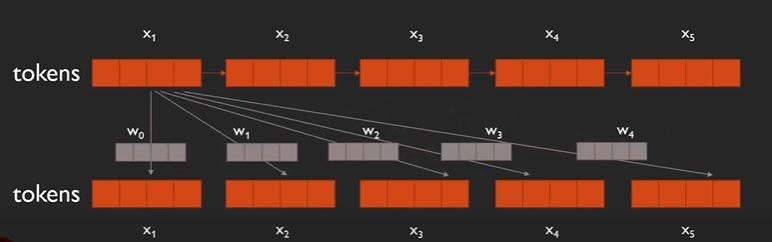

- 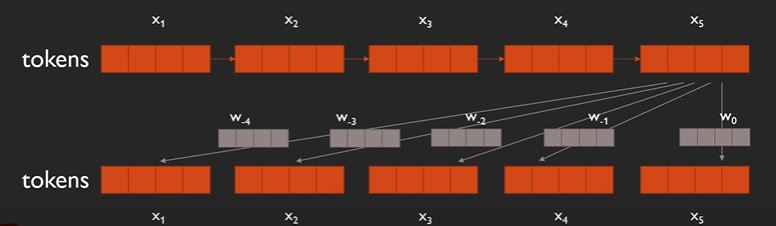


- These w vectors can be written one  under the other in a table like this.

- 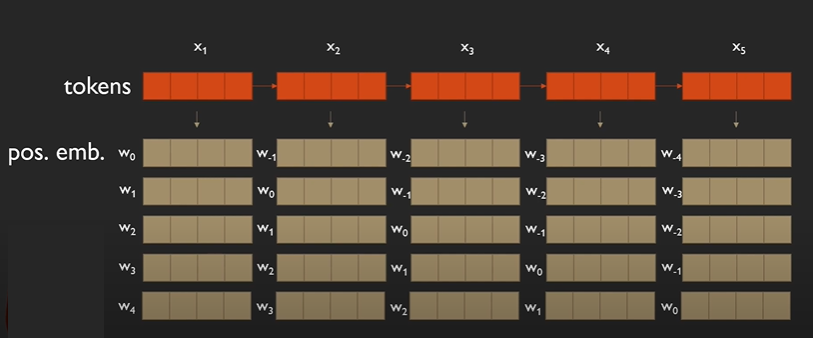

- Notice, that these vectors come from  the relationship or distance between   one token and the other so we can  use a pairwise notation for this.

- 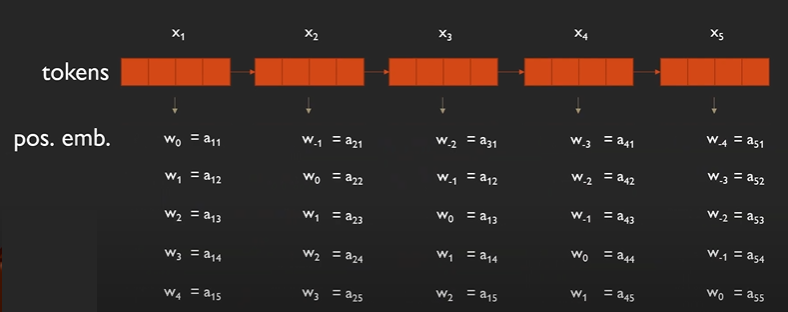

- The authors also experiment with clipping  at k, meaning that after a certain distance,  positional embeddings get the same value. So for k=2: w_3 and w_4 all take the value of w_2.

Reason:when sequences become very long, maintaining unique positional embeddings for each token can become inefficient or unnecessary beyond a certain distance. Also called bucketing relative indices.

- 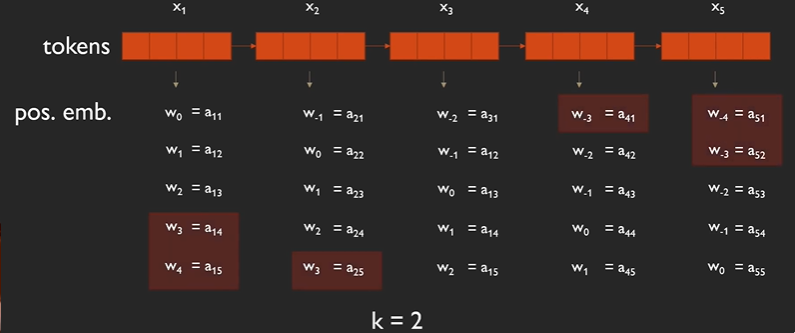

- Okay, but now for each token, we are stuck  with as many positional embeddings as the sequence has tokens, what to do with all of these? Add them all up? That wouldn’t be a great idea:  addition is complicating things even with  sinusoidal embeddings where we have just one positional encoding for each token because we could mix up the semantic(EMBDEDDING) and positional information.

- With 5 positional  embeddings per token, the  mixing-up problem would be only 5 times larger... if only we had a mechanism that given a token,computes new representations for that token  in relationship to all other tokens ...

SOLUTION???

Well, we do have this, it’s the self-attention  mechanism! A clever idea would be to modify  the self-attention formulas to capture the  relative positional representations too.We remember that through self-attention,  each token gets a new representation.

## Lets Build Relative Positioning Scalar

## ✏ ✏ ✏ ✏ ✏ ✏ ✏ ✏ To Do ✏ ✏ ✏ ✏ ✏ ✏ ✏ ✏
1. Initialize few variables num_buckets=6 (the total number of index buckets where we will spread or clip our indices into),
   max_distance=20 (maximum sequence length), q_len =14(query length / input sequence length), k_len=14 (key length) since our attention matrix is computed on query and key matrices. **Note:** These are from (-2) dimension of the query, Q' and keys K' that are simultaneously passed for matrixmul in regular attention map; i.e,
query: query shape == (batch_size, n_heads, seq_len_q, depth)
and key: key shape == (batch_size, n_heads, seq_len_k, depth)

2. Construct Relative position matrix - The Scalar !!(Size must match the attention matrix)

-  Create context_pos and memory_pos tensors of type long, utilizing q_len and k_len respectively, print the tensor values. This will depict the range of query and key tokens.
-  To attain relative poistion matrix (rpe), memory_pos needs to be subtracted with context_pos column vector

3. Good Job 👍 Now considering the Decoder Model. We need to mask the upper triangle of the rpe matrix with (0's) and for lower traingle instead of negative indexes a positive relative distance is more convinient. Apply this effect on your rpe matrix and dipaly the output. Hurray! your decoder rpe is ready!!! ✨ ✨ ✨

4. Now For T5 modifications!! Since we have limited num_buckets(lets say 6), we need to create max_exact that decides which buckets are going to be the exact index (lets say 1,2) and beyond that things will be piled up lograthimically. We need 2 Masks for that:

- max_exact variable could initialized with half of the buckets for exact increments in positions so that the index is preserved for these no. of indexes.First Mask is boolean mask (is_small) where we will see the indexes less than the max_exact in our rpe matrix.display your result. Ofcourse top triangle will all be True.

- Now for second mask i.e, Lograthimically scale up indexes into the remaining buckets (lets say 4 buckets if we had total 6 buckets initially). Means ,the other half of the buckets are for logarithmically bigger bins in positions up to max_distance. So, we map a positional embeddings up to a number k exactly (offset by 1, offset by 2, offset by 3...) but at a certain point we have a longer sequence than positional embedding "buckets" (like bins), so we map them logarithmically to spread out over our fixed number of buckets: e.g. [1,2,3,3,3,4,4,5,5,5,6,6,6]

 Apply this code to achieve this where n=rpe matrix!!! This function maps indices logarithmically over a fixed number of buckets. Display results , Observe closely 🔍 & discuss!!!
 >>>>
 val_if_large = max_exact + \
  (
    torch.log(n.float() / max_exact)  # log of matrix divided by scalar
    / math.log(max_distance / max_exact) * (num_buckets - max_exact) # scalar
    ).long() # convert float to int
 val_if_large = max_exact + (torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact))


   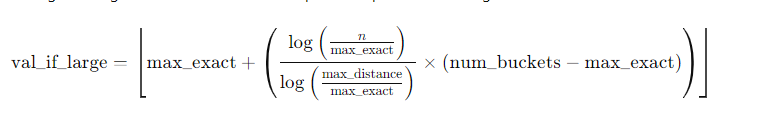

   - Convert the results into type long ,for integer transformation and observe the results, again for the second mask.

5. Now the two masks will be applied to the rpe matrix to attain the relative positioning encodings scheme (position_bucket_indices). Use torch.where(condition,True, False) construct to apply these masks on the rpe matrix. is_Small will be placed in condition to retain the max_exact relative position indexes in rpe matrix and for lograthimically scaled indexes val_if_large will be applied to rpe matrix in False argument. Observe 🔍 your (position_bucket_indices) results.

6. Now we use these index into a positional embedding matrix, such that for a relative index lets say 3 we will pull out embedding for 3rd index and add into attention map. right now these are initialzed randomly , and are trained with the model and this will just get added on top of attention scores, but they are one each positional matrix for each head. lets declare 4 heads.Create a relative_position_bias with an embedding layer of num_bucks x heads, display its shape and the weights corresponding to heads.

7. Now we need to add index into this with our matrix, relative_position_values = relative_position_bias(position_bucket_indices) print the shape .

8. Wrap up everything into a nice Relative Position Encoding class.test it!!! Recall the shape of MatMul Q, K-transpose where this scalar needs to be added.Reshape it accordingly. Show the resultant shape. Hint: # Rearrange (sequence, context, heads) -> (1, heads, sequence, context)

Your Complete Solution Here!

In [ ]:
# Initialize variables
num_buckets=6
max_distance=20
q_len =14
k_len =14

# Create context_pos and memory_pos tensors of type long, utilizing q_len and k_len respectively, print the tensor values. This will depict the range of query and key tokens
context_pos = torch.arange(q_len, dtype=torch.long)[:, None]
memory_pos = torch.arange(k_len, dtype=torch.long)

# print("context_pos:", context_pos)
# print("memory_pos:", memory_pos)

# Construct Relative position matrix - The Scalar
rpe = memory_pos - context_pos
print("RPE:\n", rpe)

# Now considering the Decoder Model. We need to mask the upper triangle of the rpe matrix with (0's) and for lower traingle instead of negative indexes a positive relative
# distance is more convinient. Apply this effect on your rpe matrix and dipaly the output.
rpe = np.tril(rpe)
rpe = torch.from_numpy(rpe)
rpe = rpe.abs()
# print("Masked RPE:\n", rpe)

# Now For T5 modifications!! Since we have limited num_buckets(lets say 6), we need to create max_exact that decides which buckets are going to be the exact index
# (lets say 1,2) and beyond that things will be piled up lograthimically.
# max_exact variable could initialized with half of the buckets for exact increments in positions so that the index is preserved for these no. of indexes.
# First Mask is boolean mask (is_small) where we will see the indexes less than the max_exact in our rpe matrix.display your result. Ofcourse top triangle will all be True.
max_effect = num_buckets // 2
is_small = rpe < max_effect
print("is_small\n", is_small)
print()

# val_if_large = max_exact + ( torch.log(n.float() / max_exact) # log of matrix divided by scalar / math.log(max_distance / max_exact) * (num_buckets - max_exact) # scalar ).long()
# convert float to int val_if_large = max_exact + (torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact))
val_if_large = max_effect + (torch.log(rpe.float() / max_effect) / math.log(max_distance / max_effect) * (num_buckets - max_effect)).long()
# print("val_if_large\n", val_if_large)

# Now the two masks will be applied to the rpe matrix to attain the relative positioning encodings scheme (position_bucket_indices).
# Use torch.where(condition,True, False) construct to apply these masks on the rpe matrix. is_Small will be placed in condition to retain the max_exact
# relative position indexes in rpe matrix and for lograthimically scaled indexes val_if_large will be applied to rpe matrix in False argument.
position_bucket_indices = torch.where(is_small, rpe, val_if_large)
print("position_bucket_indices\n", position_bucket_indices)
print()

# Now we use these index into a positional embedding matrix, such that for a relative index lets say 3 we will pull out embedding for 3rd index and add
# into attention map. right now these are initialzed randomly , and are trained with the model and this will just get added on top of attention scores,
# but they are one each positional matrix for each head. lets declare 4 heads.Create a relative_position_bias with an embedding layer of num_bucks x heads,
# display its shape and the weights corresponding to heads.
relative_position_bias = nn.Embedding(num_buckets, 4)
print("Shape of rpb", relative_position_bias.weight.shape)
print("Weight of rpb\n", relative_position_bias.weight)

# Now we need to add index into this with our matrix, relative_position_values = relative_position_bias(position_bucket_indices) print the shape.
# Rearrange (sequence, context, heads) -> (1, heads, sequence, context)
relative_position_values = relative_position_bias(position_bucket_indices)
print("Shape of relative_position_values", relative_position_values.shape)

# Wrap up everything into a nice Relative Position Encoding class.test it!!! Recall the shape of MatMul Q, K-transpose where this scalar needs to be added.
# Reshape it accordingly. Show the resultant shape. Hint: # Rearrange (sequence, context, heads) -> (1, heads, sequence, context)
relative_position_values = relative_position_values.permute(2, 0, 1).unsqueeze(0)
print("Shape of Positional Encoding", relative_position_values.shape)


RPE:
 tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13],
        [ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
        [ -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
        [ -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
        [ -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
        [ -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8],
        [ -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7],
        [ -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6],
        [ -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5],
        [ -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4],
        [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3],
        [-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2],
        [-12, -11, -10,  -9,  -8, 

## Concluding Remarks:

Relative positioning enhances the model’s ability to understand sequential relationships and dependencies within the input sequences.

In T5, if your model specifies a bucket size of 32, this means that relative positions are grouped into 32 discrete buckets based on their distance.

Each bucket will contain relative position embeddings that correspond to a specific range of distances.

Each bucket will have its own learned embeddings for relative positions, aiding the model in capturing dependencies at different distances efficiently.

Each head's relative position matrix typically includes 32 such buckets, facilitating efficient computation of attention mechanisms across sequences in a scalable manner.

# Module 2 - Continued

In [ ]:
"""
C02. Scaled dot product attention
"""
class ScaledDotProductAttention(nn.Module):
    """Calculate the attention weights.
    query, key, value must have matching leading dimensions.
    key, value must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.


    Args:
        query: query shape == (batch_size, n_heads, seq_len_q, depth)
        key: key shape     == (batch_size, n_heads, seq_len_k, depth)
        value: value shape == (batch_size, n_heads, seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (batch_size, n_heads, seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """
    def __init__(self):
        super().__init__()

        #drop out to avoid overfitting
        self.dropout = nn.Dropout(0.3) #Dropout is applied throughout the network (e.g., attention weights, feed forward network, skip connection, etc.)
        # Relative positions are often discretized into buckets to reduce computational complexity.
        # Each bucket typically represents a range of relative distances between tokens.
        # positions that are close together might be grouped into one bucket, while positions that are farther apart might be grouped into another.
        # Each attention head (8 heads) will have its own set of relative position embeddings.
        self.num_buckets = 32
        self.relative_attention_bias = torch.nn.Embedding(self.num_buckets, n_heads) #32 ranges in pos relative matrix for each head


    def forward(self, query, key, value, mask, bidirectional=True):

        qlen, klen = query.size(-2), key.size(-2) #(1,8,20,64) second last dimension for the range
        # print("For Omega")
        # print("qlen", qlen) # q sequence lenth for omega
        # print("klen", klen) # k sequence lenth for omega
        # print()
        # 1. MatMul Q, K-transpose. Attention score matrix.
        matmul_qk = torch.matmul(query, torch.transpose(key,2,3))  #q(1,8,20,64) #k(1,8,64,20)
        # print("matmul Q.K(transpose)",matmul_qk.shape) #for 8 heads relationship between seq x seq
        # print()


        # 2. scale matmul_qk
        # Divide by the root of dk.
        dk = key.shape[-1]
        # print("dk", dk)
        scaled_attention_logits = matmul_qk / math.sqrt(dk)
        # print("scaled_attention_logits (div by sqrt(dk))",scaled_attention_logits.shape)
        # print()

        # print("Add Omega in the equation") #should be of shape (1,8,20,20)
        position_bias = self.compute_bias(qlen, klen, bidirectional=bidirectional)
        # print("position_bias",position_bias.shape)
        # print()

        scaled_attention_logits += position_bias
        # print("scaled_attention_logits with omega added", scaled_attention_logits)


        # Masking. Put a very small negative value in the position to be masked in the attention score matrix.
        # Since it is a very small value, the value at the corresponding position in the matrix becomes 0 after passing the softmax function.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  #Multiplying the mask by -1e9 creates a tensor of very large negative values (-1e9), where True positions in the mask become -1e9, and False positions become 0.

        # 4. softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
        # attention weight : (batch_size, n_heads, sentence length of query, sentence length of key)
        attention_weights = F.softmax(scaled_attention_logits, dim=-1) #(1,8,20,20)
        # print("final attention weights for 8 heads after softmax",attention_weights.shape)
        # print()

        # 5. MatMul attn_prov, V
        # output : (batch_size, n_heads, sentence length of query, hid_dim/n_heads)
        output = torch.matmul(attention_weights, value) #(1,8,20,20) @ (1,8,20,64)
        # print("final output multiplication with V",output.shape)
        # print()

        return output, attention_weights

    def compute_bias(self, qlen, klen, bidirectional=True):
        context_position = torch.arange(qlen, dtype=torch.long)[:, None]
        # print("context_position",context_position)

        memory_position = torch.arange(klen, dtype=torch.long)[None, :]
        # print("memory_position",memory_position)

        relative_position = memory_position - context_position
        # print("rel pos",relative_position)

        rp_bucket = self._relative_position_bucket(
            relative_position,  # shape (qlen, klen)
            num_buckets=self.num_buckets,
            bidirectional=bidirectional
        )
        # (qlen, klen)
        #f self.relative_attention_bias is a tensor or a module residing on a GPU, self.relative_attention_bias.weight.device would tell you which GPU (like cuda:0) it's on.
        rp_bucket = rp_bucket.to(self.relative_attention_bias.weight.device)
        # (qlen, klen, n_head)
        values = self.relative_attention_bias(rp_bucket)
        # print("values",values.shape)
        # (1, n_head, qlen, klen)
        values = values.permute([2, 0, 1]).unsqueeze(0)  #adjusting shape
        # print("final values",values)
        return values


    def _relative_position_bucket(self, relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        ret = 0
        n = -relative_position
        # print("negative_relativepos",n)
        if bidirectional:
            num_buckets //= 2
            # print((n < 0))
            # print((n < 0).to(torch.long) * num_buckets)
            ret += (n < 0).to(torch.long) * num_buckets  # mask with buckets
            # print("ret", ret)
            n = torch.abs(n)
            # print("n",n)
        else:
            n = torch.max(n, torch.zeros_like(n))  #for decoder part
            # print("n",n)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2  #8 is the max_exact
        # print("maxexact", max_exact)
        is_small = n < max_exact
        # print("is_small", is_small) #mask 1 applied on n


        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        val_if_large = max_exact + (
                torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)
        ).to(torch.long)
        # print(val_if_large)
        # print(torch.full_like(val_if_large, num_buckets - 1))
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))
        # print("val_if_large",val_if_large) #mask 2
        # print(torch.where(is_small, n, val_if_large))
        ret += torch.where(is_small, n, val_if_large) #torch.where(condition, x, y)

        # print("bucketed rel position before weights",ret)
        return ret

04 Lab Tasks Ahead

Test ScaledDotProductAttention - Lab Task

In [ ]:
# defined n_heads, query, key, value, and mask in your code snippet where query ,key and value are 4D tensors of shape(batch,n_heads,seq,dk)
# value for number of heads
#  query tensor
#  key tensor
#  value tensor

n_heads = 8
query = torch.randn(1, n_heads, 20, 64)
key = torch.randn(1, n_heads, 20, 64)
value = torch.randn(1, n_heads, 20, 64)
mask = None

# Instantiate ScaledDotProductAttention
scaled_dot_product_attention = ScaledDotProductAttention()

# Call the Forward method and display the output and attention_weights
output, attention_weights = scaled_dot_product_attention(query, key, value, mask)

print("Attention weights shape:", attention_weights.shape)
print("Output shape:", output.shape)

Attention weights shape: torch.Size([1, 8, 20, 20])
Output shape: torch.Size([1, 8, 20, 64])


recall multi-head attention from Original transformer

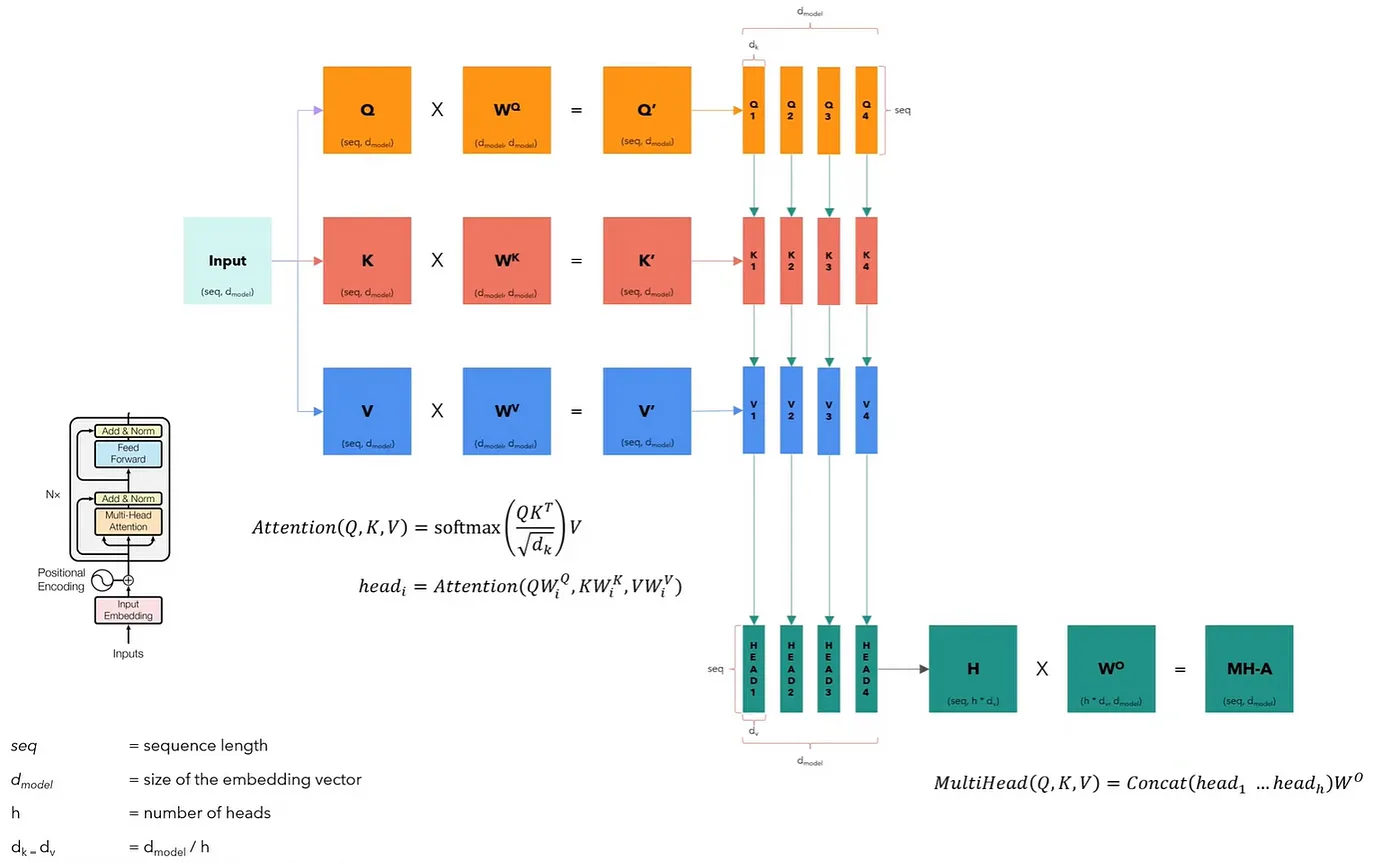

In [ ]:
"""
C03. Multi head attention
"""
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, hid_dim, n_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        self.n_heads = n_heads
        assert hid_dim % self.n_heads == 0
        self.hid_dim = hid_dim   #d_model

        # hid_dim divided by n_heads.
        self.depth = int(hid_dim/self.n_heads)  #dk

        # Define dense layers corresponding to WQ, WK, and WV
        self.q_linear = nn.Linear(hid_dim, hid_dim)
        self.k_linear = nn.Linear(hid_dim, hid_dim)
        self.v_linear = nn.Linear(hid_dim, hid_dim)

        self.scaled_dot_attn = ScaledDotProductAttention() #initialization only

        # the original number of dimensions of the word vector
        self.out = nn.Linear(hid_dim, hid_dim) #WO

    def split_heads(self, inputs, batch_size):
        """Split the last dimension into (n_heads, depth).
        Transpose the result such that the shape is (batch_size, n_heads, seq_len, depth)
        """
        inputs = torch.reshape(
            inputs, (batch_size, -1, self.n_heads, self.depth)) # from(1,20,512) to (1,20,8,64)
        return torch.transpose(inputs, 1,2)  #(1,8,20,64) for head splits

    def forward(self, inputs, bidirectional=False):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']  #input(1,20,512)
        # print()
        # print("Q",query.shape)

        # print("K",key.shape)

        # print("V",value.shape)
        # print()

        # print("Wq, Wk and Wv of dimension 512x512, d_model x d_model")
        # print()
        batch_size = query.shape[0]

        # 1. Pass through the dense layer corresponding to WQ
        # q : (batch_size, sentence length of query, hid_dim)
        query = self.q_linear(query)  #Q'
        # print("Q'",query.shape)

        # split head
        # q : (batch_size, n_heads, sentence length of query, hid_dim/n_heads)
        query = self.split_heads(query, batch_size)
        # print("headsplit Q'",query.shape)
        # print()

        # 2. Pass through the dense layer corresponding to WK
        # k : (batch_size, sentence length of key, hid_dim)
        key   = self.k_linear(key)   #K'
        # print("K'",key.shape)

        # split head
        # k : (batch_size, n_heads, sentence length of key, hid_dim/n_heads)
        key   = self.split_heads(key, batch_size)
        # print("headsplit K'",key.shape)
        # print()

        # 3. Pass through the dense layer corresponding to WV
        # v : (batch_size, sentence length of value, hid_dim)
        value = self.v_linear(value)  #V'
        # print("V'",value.shape)


        # split head
        # v : (batch_size, n_heads, sentence length of value, hid_dim/n_heads)  #(1,8,20,64)
        value = self.split_heads(value, batch_size)
        # print("headsplit V'",value.shape)
        # print()

        # 4. Scaled Dot Product Attention. Using the previously implemented function
        # (batch_size, n_heads, sentence length of query, hid_dim/n_heads)
        # scaled_attention, _ = ScaledDotProductAttention(query, key, value, mask)
        scaled_attention, _ = self.scaled_dot_attn(
            query, key, value, mask, bidirectional = bidirectional) #output from each head (1,8,20,64)

        # (batch_size, sentence length of query, n_heads, hid_dim/n_heads)
        scaled_attention = torch.transpose(scaled_attention, 1,2) #(1,20,8,64)

        # 5. Concatenate the heads
        # (batch_size, sentence length of query, hid_dim)
        concat_attention = torch.reshape(scaled_attention,
                                      (batch_size, -1, self.hid_dim))  #(1,20,512) back to original input shape

        # 6. Pass through the dense layer corresponding to WO
        # (batch_size, sentence length of query, hid_dim)
        outputs = self.out(concat_attention) #MHA.WO  (1,20,512) with (512,512)
        # print("After concatenation of heads back to shape as of input", outputs.shape)

        return outputs

In [ ]:
"""
C04. Positionwise Feedforward Layer
"""
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim):
        super(PositionwiseFeedforwardLayer, self).__init__()
        self.linear_1 = nn.Linear(hid_dim, pf_dim)  #512 in input and in hidden unit
        self.linear_2 = nn.Linear(pf_dim, hid_dim)

    def forward(self, attention):
        output = self.linear_1(attention)
        output = F.relu(output)
        output = self.linear_2(output)
        return output

In [ ]:
"""
C05. Encoder layer
"""
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()

        self.attn = MultiHeadAttentionLayer(hid_dim, n_heads)
        self.ffn  = PositionwiseFeedforwardLayer(hid_dim, pf_dim)

        self.layernorm1 = nn.LayerNorm(hid_dim)
        self.layernorm2 = nn.LayerNorm(hid_dim) #normaliziation will be applied to the d_model

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, inputs, padding_mask):

        # 1. Encoder mutihead attention is defined
        attention   = self.attn({'query': inputs, 'key': inputs, 'value': inputs, 'mask': padding_mask}) #input is (1,20,512) call to forward MultiHeadAttentionLayer
        attention   = self.dropout1(attention)
        # print()
        # print("Applying drop out 2 after concat", attention.shape)

        # 2. 1 st residual layer
        attention   = self.layernorm1(inputs + attention)  # (batch_size, input_seq_len, hid_dim)
        #After adding inputs and attention, the combined result undergoes normalization using self.layernorm1. Layer normalization normalizes the activations across the feature dimension (hid_dim in this case), ensuring stable gradients and faster training.
        # print("Applying first risudual before feed forward", attention.shape)

        # 3. Feed Forward Network
        ffn_outputs = self.ffn(attention)  # (batch_size, input_seq_len, hid_dim)
        # print("Feed forward output",ffn_outputs.shape)

        ffn_outputs = self.dropout2(ffn_outputs)
        # print("Applying drop out 2 after feed forward", ffn_outputs.shape)

        # 4. 2 nd residual layer
        ffn_outputs = self.layernorm2(attention + ffn_outputs)  # (batch_size, input_seq_len, hid_dim)
        # print("Applying second risudual after feed forward", ffn_outputs.shape)

        # 5. Encoder output of each encoder layer
        return ffn_outputs

In [ ]:
"""
C06. Encoder
"""
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.embedding    = nn.Embedding(n_enc_vocab, hid_dim) #mapping of tokens into embedding vectors
        self.enc_layers   = EncoderLayer()
        self.dropout1     = nn.Dropout(dropout)

    def forward(self, x, padding_mask):

        # adding embedding and position encoding.
        # 1. Token Embedding
        emb = self.embedding(x)  # (batch_size, input_seq_len, hid_dim) embeddings for each token index in x.
        # print("Input Embedding shape", emb.shape)
        output = self.dropout1(emb)  # Dropout is a regularization technique used during training to prevent overfitting in neural networks.
        # print("applying drop out 1 after embedding", output.shape)
        # print()
        # 3. Self padding Mask is created from encoder input

        # 4. Encoder layers are stacked
        for i in range(n_layers):
            output = self.enc_layers(output, padding_mask)  #forward of encoderLayer

        # 5. Final layer's output is the encoder output

        return output  # (batch_size, input_seq_len, hid_dim)

Lab Task -test Encode Class

In [ ]:
# Size of the encoder vocabulary,n_enc_vocab
# hid_dim (its d_model)
# Number of attention heads,n_heads
# Dimensionality of the position-wise feedforward layers, pf_dim
# Dropout rate, dropout
# n_layers
#maximum_seq_length

n_enc_vocab = 100
hid_dim = 512
n_heads = 8
pf_dim = 512
dropout = 0.1
n_layers = 3
maximum_seq_length = 20

# Create and display random input tensor x  with batch_size 1 and input_seq_len 20 with values between 0 (inclusive) and n_enc_vocab
x = torch.randint(0, n_enc_vocab, (1, 15))
x = pad_sequences(x,  maxlen=maximum_seq_length, padding='post', truncating='post')
x = torch.tensor(x)
print(x)

# before feeding data into your neural network,  pad each sequence to match the maximum_seq_length using a padding token.
# Create a padding mask for x.
padding_mask = pad_sequences(x,  maxlen=maximum_seq_length, padding='post', truncating='post')
padding_mask = torch.tensor(padding_mask)
padding_mask = (padding_mask == 0)
print(padding_mask)

#construct and display a padding_mask that marks which positions are padded (True) and which are actual tokens (False).
#This mask ensures that the model doesn't attend to the padded positions during computations.

# Initialize Encoder
encoder = Encoder()

# Forward call of Encoder here pass input tensor and padding_mask
output = encoder(x, padding_mask)

# check the shape of the output
# Should be (batch_size, input_seq_len, hid_dim)
print(output.shape)


tensor([[88, 29, 46, 89,  3, 32, 84, 54, 24, 75, 15, 72, 22, 62, 25,  0,  0,  0,
          0,  0]], dtype=torch.int32)
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True,  True,  True,  True,  True]])
torch.Size([1, 20, 512])


In [ ]:
"""
C07. Decoder layer
"""
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()

        self.attn   = MultiHeadAttentionLayer(hid_dim, n_heads)
        self.attn_2 = MultiHeadAttentionLayer(hid_dim, n_heads)

        self.ffn = PositionwiseFeedforwardLayer(hid_dim, pf_dim)

        self.layernorm1 = nn.LayerNorm(hid_dim)
        self.layernorm2 = nn.LayerNorm(hid_dim)
        self.layernorm3 = nn.LayerNorm(hid_dim)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, inputs, enc_outputs, padding_mask, look_ahead_mask):

        # 1. 1st Encoder mutihead attention is defined. Q,K,V is same and it's comes from decoder input or previous decoder output
        attention1 = self.attn(
            {'query': inputs, 'key': inputs, 'value': inputs, 'mask': look_ahead_mask})
        attention1 = self.dropout1(attention1)

        # 2. 1st residual layer
        attention1 = self.layernorm1(inputs + attention1)

        # 3. 2nd Encoder mutihead attention is defined. Q comes from Multi-Head attention. K,V are same and comes from encoder output
        attention2 = self.attn_2(
            {'query': attention1, 'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask})
        attention2 = self.dropout2(attention2)

        # 4. 2nd residual layer
        attention2 = self.layernorm2(attention1 + attention2)  # (batch_size, target_seq_len, hid_dim)

        # 5. Feed Forward Network
        ffn_outputs = self.ffn(attention2)  # (batch_size, target_seq_len, hid_dim)
        ffn_outputs = self.dropout3(ffn_outputs)

        # 6. 3 rd residual layer
        ffn_outputs = self.layernorm3(attention2 + ffn_outputs)  # (batch_size, target_seq_len, hid_dim)

        # 7. Decoder output of each decoder layer
        return ffn_outputs

In [ ]:
"""
C08. Decoder
"""
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.embedding    = nn.Embedding(n_dec_vocab, hid_dim)
        self.dec_layers = DecoderLayer()
        self.dropout      = nn.Dropout(dropout)

    def forward(self, enc_output, dec_input, padding_mask, look_ahead_mask):

        # 1. Decoder input Token Embedding
        emb = self.embedding(dec_input)
        output = self.dropout(emb)

        # 3. Padding mask is created from **encoder inputs** in this implementation
        # 4. Look ahead Mask is created from **decoder inputs**
        # 5. Decoder layers are stacked
        for i in range(n_layers):
            output = self.dec_layers(output, enc_output, padding_mask, look_ahead_mask) # forward call,one input from decoder input other input is from encoder output


        # 6. Final layer's output is the decoder output

        return output

In [ ]:
"""
C09. Attention pad mask to avoid attention score mask
"""
def create_padding_mask(x):
    input_pad = 0
    mask = (x == input_pad).float()  # creates a binary mask where True indicates the presence of a padding token (0),float ensures that we can perform arithmetic operations with the mask.
    mask = mask.unsqueeze(1).unsqueeze(1) # reshape (batch_size, 1, 1, key)

    return mask

Lab Task- test padding mask on sequnces of length 5 with batch_size 2

In [ ]:
# Original tensor x (batch_size=2, seq_length=5)
x = torch.randint(0, 20, (2, 5))

# Create padding mask of Original tensor x
padding_mask = pad_sequences(x,  maxlen=10, padding='post', truncating='post')
padding_mask = torch.tensor(padding_mask)
padding_mask = (padding_mask == 0)

# Print original tensor and mask
print(x)
print(padding_mask)

tensor([[ 6,  3, 14,  6, 18],
        [ 9, 13, 19,  7, 10]])
tensor([[False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True]])


In [ ]:
"""
C10. Attention decoder mask (Look Ahead Mask)
"""
#to create a mask that prevents the decoder from attending to future tokens during self-attention, ensuring that each position can only attend to previous positions.
def create_look_ahead_mask(seq):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seq_len = seq.shape[1] #calculates the length of the sequence seq.
    look_ahead_mask = torch.ones(seq_len, seq_len) # initializes a square matrix of ones with dimensions (seq_len, seq_len). This matrix initially allows full attention across all positions.

    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1).to(device) #upper triangle is masked ensuring that the decoder attends only to previous positions and not to future ones.maintaining the autoregressive property essential for generating sequences sequentially.
    # padding_mask = create_padding_mask(seq).to(device) # including a padding mask
    # return torch.maximum(look_ahead_mask, padding_mask)

    return look_ahead_mask

Lab Task- Test LookAhead Mask on sequence length of 5 with batch size 1

In [ ]:
# sequence tensor (batch_size=1, seq_length=5)
x = torch.randint(0, 20, (1, 5))

# Create look-ahead mask
look_ahead_mask = create_look_ahead_mask(x)

# Print original sequence and mask
print(x)
print("==="*20)
print(look_ahead_mask)

tensor([[ 3, 10, 16, 16,  5]])
tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])


In [ ]:
"""
C12. T5 Class
"""
class Transformer(nn.Module):
    def __init__(self, n_enc_vocab, n_dec_vocab,    #10 parameters required
                 n_layers, pf_dim, hid_dim, n_heads,
                 pe_input, pe_target, dropout):
        super(Transformer, self).__init__()

        # Ecoder and Decoder
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.fin_output = nn.Linear(hid_dim, n_dec_vocab)
        self.softmax = nn.LogSoftmax(dim=-1)  #columns wise
#1,41 enc_inputs and 1,1 dec_inputs at the begining
    def forward(self, enc_inputs, dec_inputs):
        # 1. Encoder Padding Mask
        enc_padding_mask = create_padding_mask(enc_inputs) #pad 0's with 1
        # 2. Dec Padding Mask
        dec_padding_mask = create_padding_mask(enc_inputs)  #pad 0's with 1
        # 3. Look ahead Mask
        look_ahead_mask  = create_look_ahead_mask(dec_inputs) # create a square matrix where, upper tri masked with 1's for current dec_input seq
        dec_target_padding_mask = create_padding_mask(dec_inputs).to(device) #pad 0's with 1
        look_ahead_mask  = torch.maximum(dec_target_padding_mask, look_ahead_mask)

        enc_output = self.encoder(enc_inputs, enc_padding_mask)
        # 4. Encoder outputs are created from encoder model and it is given to the "Key" and "Value" of Multi-Head Attention 2 of decoder layers
        dec_output = self.decoder(enc_output, dec_inputs, dec_padding_mask, look_ahead_mask)
        # 5. Decoder output is creadted from decoder model

        final_output = self.fin_output(dec_output)

        # 6. Final outputs are created. Then it is used or Language Model. In the official tutorial "Softmax" was missed
        return final_output

ask huma for final softmax and look ahead mask in scaled dot product :if mask is not none condition

# Module 3- Training and Inference

Training

In [ ]:
# Model Define for Training
model = Transformer(
    n_enc_vocab = n_enc_vocab,
    n_dec_vocab = n_dec_vocab,
    n_layers  = n_layers,
    pf_dim      = pf_dim,
    hid_dim     = hid_dim,
    n_heads     = n_heads,
    pe_input    = 512,
    pe_target   = 512,
    dropout     = dropout)

model.to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# Network initialization
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner layer initialization"
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# TransformerBlock Module initialization settings
model.apply(initialize_weights)

import os.path

if os.path.isfile('./checkpoints/transformermodel.pt'):
    model.load_state_dict(torch.load('./checkpoints/transformermodel.pt'))

print('Network initialization complete')

# Definition of the loss function
criterion = nn.CrossEntropyLoss()

# Optimization setup
# learning_rate = 2e-4
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

from IPython.display import clear_output
import datetime

Model_start_time = time.time()

# training
def train(epoch, model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    with tqdm_notebook(total=len(dataloader), desc=f"Train {epoch+1}") as pbar:
        for batch_idx, samples in enumerate(dataloader):
            src_inputs, trg_outputs = samples

            with torch.set_grad_enabled(True):
                # Transformer Input
                logits_lm = model(src_inputs, trg_outputs)

                pad = torch.LongTensor(trg_outputs.size(0), 1).fill_(0).to(device)
                preds_id = torch.transpose(logits_lm,1,2)
                labels_lm = torch.cat((trg_outputs[:, 1:], pad), -1)

                optimizer.zero_grad()
                loss = criterion(preds_id, labels_lm)  # loss 계산
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                epoch_loss +=loss.item()

            pbar.update(1)
            # pbar.set_postfix_str(f"Loss {epoch_loss.result():.4f} Accuracy {train_accuracy.result():.4f}")
            # pbar.set_postfix_str(f"Loss {loss.result():.4f}")

    return epoch_loss / len(dataloader)

CLIP = 0.5

epoch_ = []
epoch_train_loss = []
# Speedup once the network stabilizes
torch.backends.cudnn.benchmark = True
# epoch loop
best_epoch_loss = float("inf")

for epoch in range(N_EPOCHS):

    train_loss = train(epoch, model, dataloader, optimizer, criterion, CLIP)

    if train_loss < best_epoch_loss:
        if not os.path.isdir("checkpoints"):
            os.makedirs("checkpoints")
        best_epoch_loss = train_loss
        torch.save(model.state_dict(), './checkpoints/transformermodel.pt')

    epoch_.append(epoch)
    epoch_train_loss.append(train_loss)
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

    # print('Epoch {0}/{1} Average Loss: {2}'.format(epoch+1, N_EPOCHS, epoch_loss))
    # clear_output(wait = True)

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(epoch_,epoch_train_loss, label='Average loss')

ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()

Inference

In [ ]:
# Predict the trained model
trained_model = Transformer(
    n_enc_vocab = n_enc_vocab,  #10 required parameter passed
    n_dec_vocab = n_dec_vocab,  #vocabulary sizes (n_enc_vocab for encoder and n_dec_vocab for decoder)
    n_layers    = n_layers,
    pf_dim      = pf_dim,
    hid_dim     = hid_dim,
    n_heads     = n_heads,
    pe_input    = 512,
    pe_target   = 512,
    dropout     = dropout).to(device)
trained_model.load_state_dict(torch.load('./checkpoints/transformermodel.pt')) #Loading the state dictionary saved in this file after training T5 /Loads the trained weights and biases (parameters) of your T5 model

#evaluating and making predictions using the trained model.
def evaluate(text):

    # unk = 1 SOS = 2 EOS = 3
    text = SRC_tokenizer.texts_to_sequences([text])  # #Converts sentences in English (text) into sequences of token IDs

    text = pad_sequences(text, maxlen=ENCODER_LEN, padding='post', truncating='post')  #padding at post poistion to make all lengths 41
    print(text)
    decoder_input = [TRG_tokenizer.word_index['<sos>']]  #initializes decoder_input with the index of the <sos> (start-of-sequence) token from a tokenizer (TRG_tokenizer).
    print(decoder_input)
    input  = torch.tensor(text).to(device) #converting into tensors
    print("input text",input.shape)
    output = torch.tensor([decoder_input]).to(device)
    print("decoder input",output.shape)

    #DECODER_LEN =41
    for i in range(DECODER_LEN):
        predictions = trained_model(input, output) #forward method of Transformer class
        predictions = predictions[:, -1:, :]

        # PAD, UNK, START exclude tokens
        predicted_id = torch.argmax(predictions[:,:,3:], axis=-1) + 3
        if predicted_id == 3:  # token id of <EOS>
            predicted_id = predicted_id
            break
        output = torch.cat((output, predicted_id),-1)
    return output

def predict(text):
    prediction = evaluate(text)  #step 2
    out_list = prediction.tolist()
    out_list[0].pop(0)  #removing first element
    output_indexes = out_list[0]
    predicted_sentence = TRG_tokenizer.sequences_to_texts([output_indexes])[0] #converts output_indexes back into text
    return predicted_sentence

# pass the following random inputs/sentences for prediction
for idx in (11, 21, 31, 41, 51):
    print("Input        :", raw_src_df[idx])
    print("Prediction   :", predict(raw_src_df[idx]))  #step 1
    print("Ground Truth :", raw_trg_df[idx],"\n")

#  ---------- Thats All -------------

🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

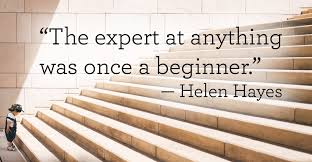

References
1. https://wikidocs.net/181234
2. https://www.youtube.com/watch?v=FhL8ksbtiYg&t=33s
3. https://cameronrwolfe.substack.com/p/t5-text-to-text-transformers-part
4. https://arxiv.org/pdf/1910.10683
5. https://www.youtube.com/watch?v=Ws2RAh_VDyU&t=236s
6. https://www.youtube.com/watch?v=DwaBQbqh5aE
7. https://arxiv.org/html/2401.09686v2
8. https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45